# Data import

In [2]:
import pandas as pd
from pathlib import Path
import re  # Import regular expressions for potentially cleaner name extraction

In [3]:
def load_performance_data(base_directory: Path) -> pd.DataFrame | None:
    """
    Loads performance test CSV data from subdirectories into a single DataFrame.

    Args:
        base_directory: The Path object pointing to the main directory
                          containing the 'perf_*' subdirectories.

    Returns:
        A pandas DataFrame containing the combined data from all CSV files,
        with an added 'lock_implementation' column, or None if no data is found.
    """
    all_dataframes = []
    processed_files = 0

    # Ensure the base directory exists
    if not base_directory.is_dir():
        print(f"Error: Base directory '{base_directory}' not found.")
        return None

    print(f"Scanning directory: {base_directory.resolve()}")

    # Iterate through items in the base directory
    for item_path in base_directory.iterdir():
        # Check if it's a directory and starts with 'perf_'
        if item_path.is_dir() and item_path.name.startswith("perf_"):
            # Extract the lock implementation type from the directory name
            # Simple replacement: lock_type = item_path.name.replace('perf_', '')
            # More robust regex if names get complex (handles cases like 'perf_lib_cpp'):
            match = re.match(r"perf_(.*)", item_path.name)
            if not match:
                print(
                    f"Warning: Could not extract lock type from directory '{item_path.name}'. Skipping."
                )
                continue
            lock_type = match.group(1)

            print(f" Found potential results directory: {item_path.name} (Lock Type: {lock_type})")

            # Find the CSV file within this subdirectory
            # Assumes only one relevant CSV per directory based on your structure
            csv_files = list(item_path.glob("*.csv"))

            if not csv_files:
                print(f"  Warning: No CSV file found in '{item_path.name}'. Skipping.")
                continue

            if len(csv_files) > 1:
                print(
                    f"  Warning: Multiple CSV files found in '{item_path.name}'. Using the first one: '{csv_files[0].name}'"
                )

            csv_path = csv_files[0]  # Use the first CSV found

            try:
                # Read the CSV file into a temporary DataFrame
                temp_df = pd.read_csv(csv_path)

                # Add the new column identifying the lock implementation
                temp_df["lock_implementation"] = lock_type

                # Append the temporary DataFrame to our list
                all_dataframes.append(temp_df)
                processed_files += 1
                print(f"  Successfully processed: {csv_path.name}")

            except pd.errors.EmptyDataError:
                print(f"  Warning: CSV file '{csv_path.name}' is empty. Skipping.")
            except Exception as e:
                print(f"  Error reading CSV file '{csv_path.name}': {e}. Skipping.")

    # Check if any dataframes were loaded
    if not all_dataframes:
        print("\nNo valid CSV data found in any 'perf_*' subdirectories.")
        return None

    # Concatenate all the individual DataFrames into one large DataFrame
    combined_df = pd.concat(all_dataframes, ignore_index=True)
    print(f"\nSuccessfully combined data from {processed_files} CSV files.")

    return combined_df

In [4]:
# --- How to use it ---

# 1. Define the path to your main results directory
#    Replace '.' with the actual path if the script is not in the parent directory
results_dir = Path("./")

# 2. Call the function to load the data
performance_df = load_performance_data(results_dir)

# 3. Check if data was loaded and display some info
if performance_df is not None:
    print("\n--- Combined DataFrame Info ---")
    performance_df.info()

    print("\n--- First 5 Rows ---")
    print(performance_df.head())

    print("\n--- Last 5 Rows ---")
    print(performance_df.tail())

    print("\n--- Unique Lock Implementations Found ---")
    print(performance_df["lock_implementation"].unique())

    # Optional: Save the combined data to a new CSV
    # output_csv_path = results_dir / 'combined_performance_results.csv'
    # performance_df.to_csv(output_csv_path, index=False)
    # print(f"\nCombined data saved to: {output_csv_path}")
else:
    print("\nFailed to create combined DataFrame.")

Scanning directory: /content/drive/MyDrive/Parallel_Computing/ParallelComputing_Exercise_01/python_data_collection/thaingo_asus/mutex
 Found potential results directory: perf_lib_openmp (Lock Type: lib_openmp)
  Successfully processed: perf_lib_openmp_20250325_182607.csv
 Found potential results directory: perf_lib_cpp (Lock Type: lib_cpp)
  Successfully processed: perf_lib_cpp_20250325_182504.csv
 Found potential results directory: perf_lib_pthreads (Lock Type: lib_pthreads)
  Successfully processed: perf_lib_pthreads_20250325_183838.csv
 Found potential results directory: perf_TAS (Lock Type: TAS)
  Successfully processed: perf_TAS_20250325_184951.csv
 Found potential results directory: perf_MCS (Lock Type: MCS)
  Successfully processed: perf_MCS_20250325_183941.csv
 Found potential results directory: perf_single_core (Lock Type: single_core)
  Successfully processed: perf_single_core_20250325_184819.csv
 Found potential results directory: perf_TTAS (Lock Type: TTAS)
  Successfully p

# Visualize execution time

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path  # Keep Path if you rerun loading
import numpy as np  # Import numpy for checking positivity if needed

In [6]:
# --- Pre-computation / Setup ---
# Make sure the DataFrame is available
if "performance_df" not in locals() or performance_df is None or performance_df.empty:
    print("Error: performance_df is not defined or is empty.")
    print("Please ensure you have run the data loading script first.")
    # Or uncomment the loading section above
    exit()  # Stop if data isn't loaded

# Check for non-positive execution times which cause issues with log scale
if (performance_df["execution_time_ms"] <= 0).any():
    print("Warning: Found zero or negative values in 'execution_time_ms'.")
    print("Logarithmic scale cannot be applied directly to non-positive values.")
    print("Consider filtering these values or adding a small constant if appropriate.")
    # Option: Filter out non-positive values before plotting
    # performance_df = performance_df[performance_df['execution_time_ms'] > 0].copy()
    # Or handle specific plots where this occurs

# Improve plot aesthetics (optional)
sns.set_theme(style="whitegrid")

# Get unique values for iteration (ensure consistent ordering if desired)
unique_locks = sorted(performance_df["lock_implementation"].unique())
unique_threads = sorted(performance_df["threads"].unique())
unique_percentages = sorted(performance_df["inside_percentage"].unique())

print(f"Found Locks: {unique_locks}")
print(f"Found Thread Counts: {unique_threads}")
print(f"Found Inside Percentages: {unique_percentages}")

Found Locks: ['MCS', 'TAS', 'TAS_EBO', 'TTAS', 'TTAS_EBO', 'lib_cpp', 'lib_openmp', 'lib_pthreads', 'single_core']
Found Thread Counts: [np.int64(1), np.int64(2), np.int64(4), np.int64(8), np.int64(16)]
Found Inside Percentages: [np.float64(10.0), np.float64(30.0), np.float64(50.0), np.float64(70.0), np.float64(90.0)]


## Bar plot


--- Generating Plots: Request 1 (Per Lock Type, Log Scale) ---


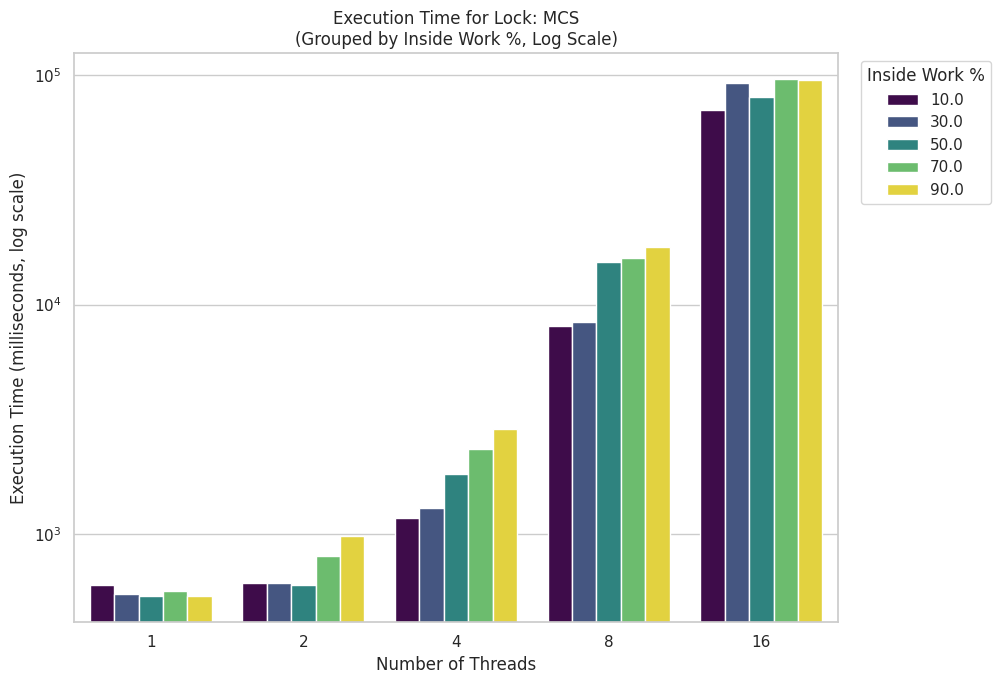

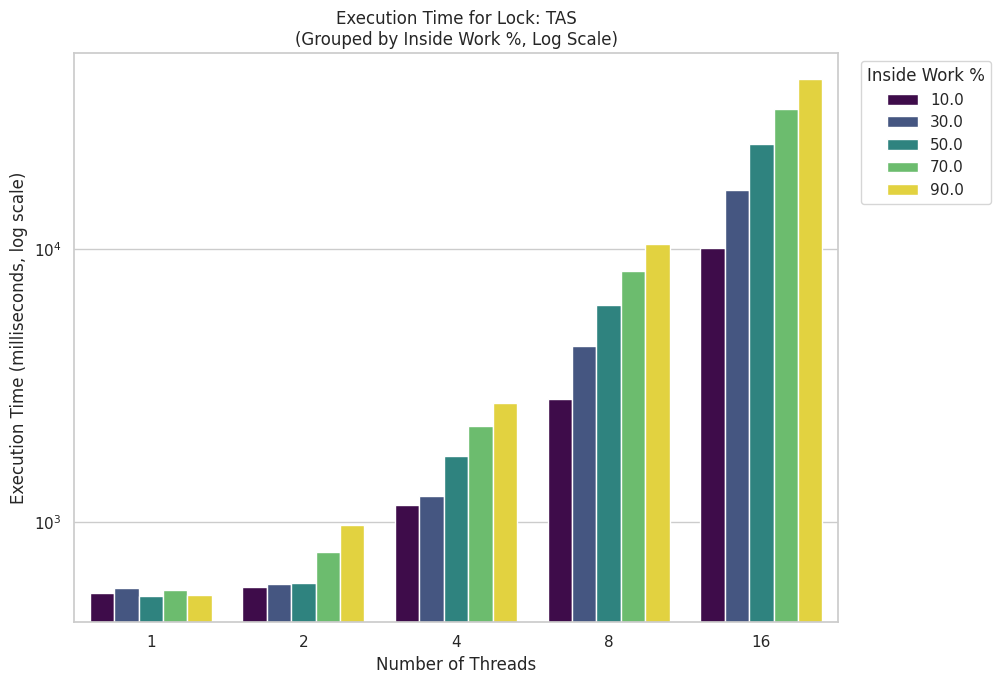

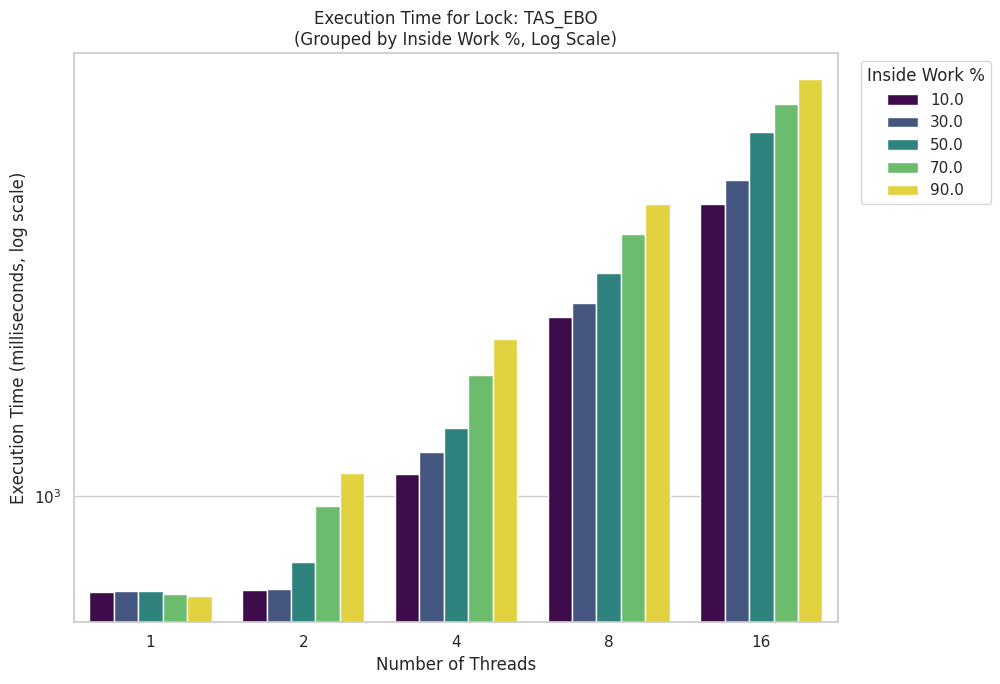

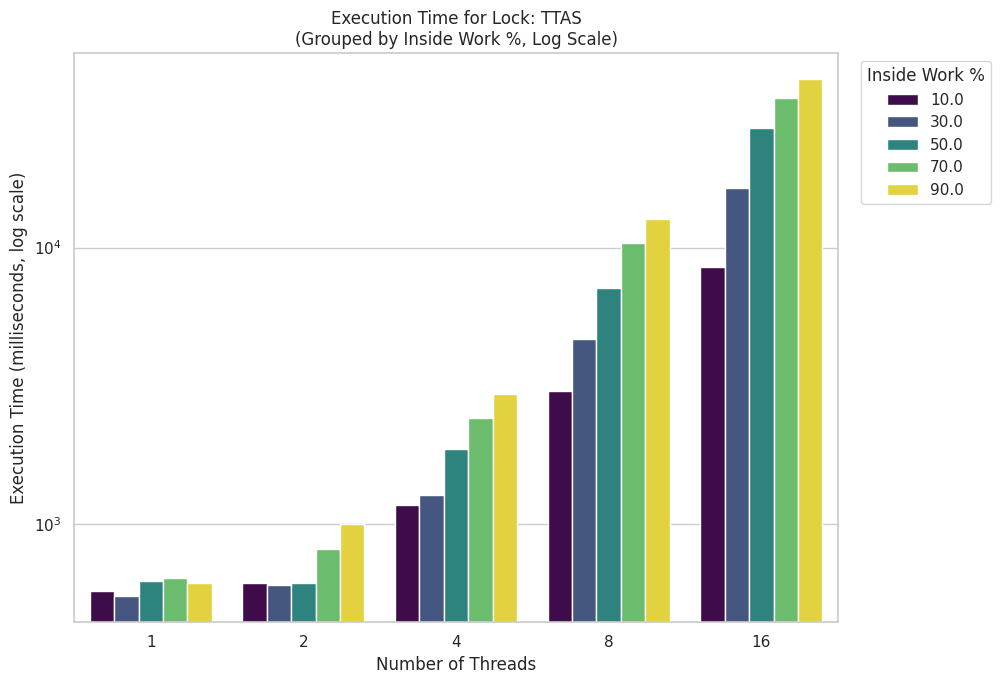

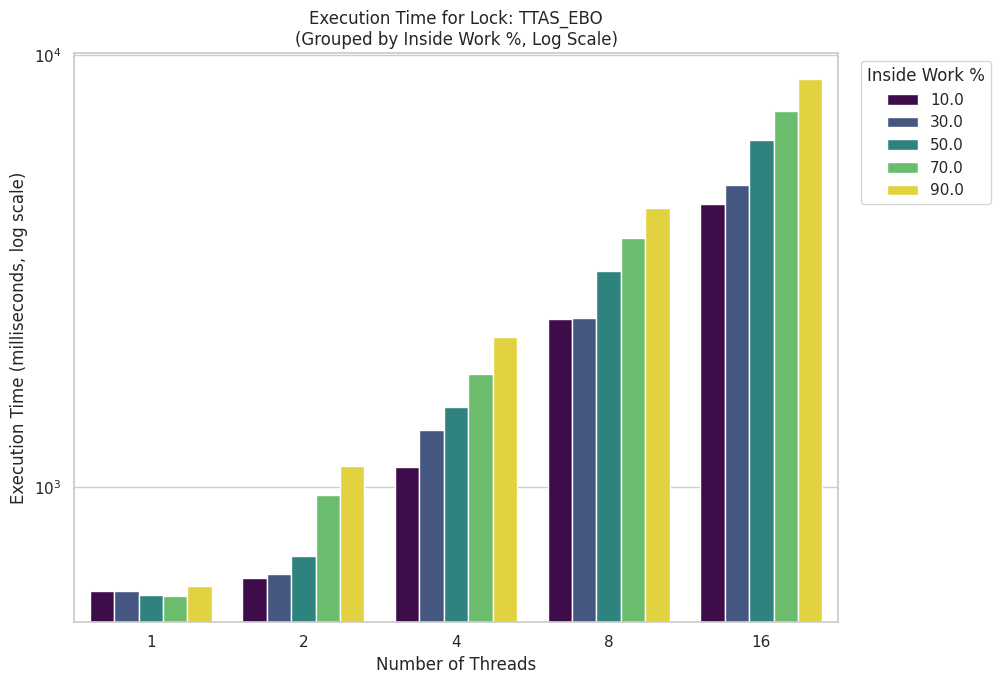

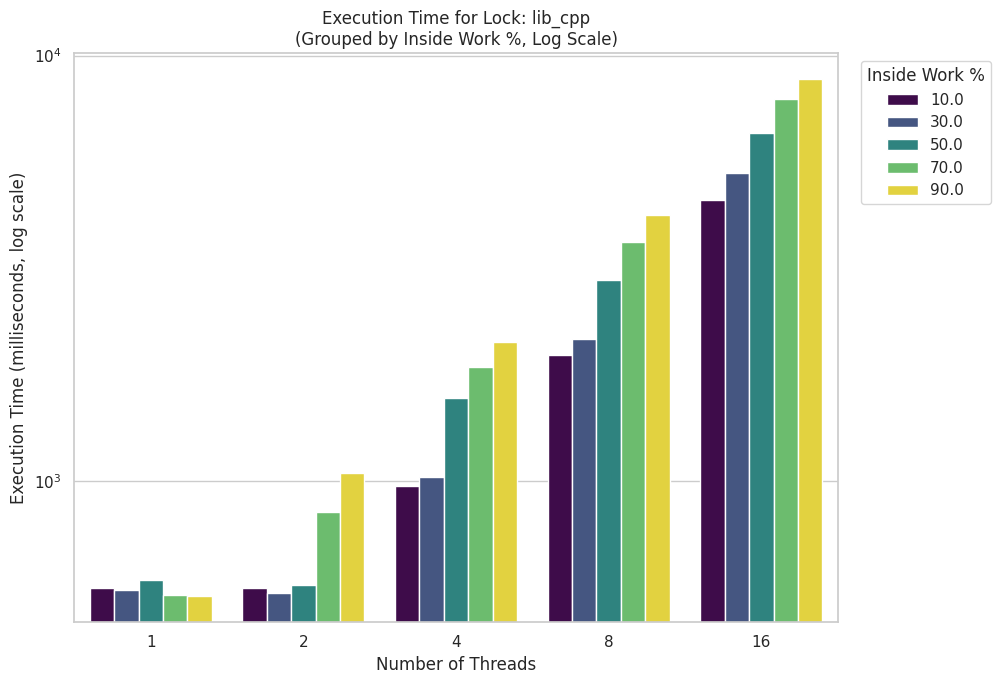

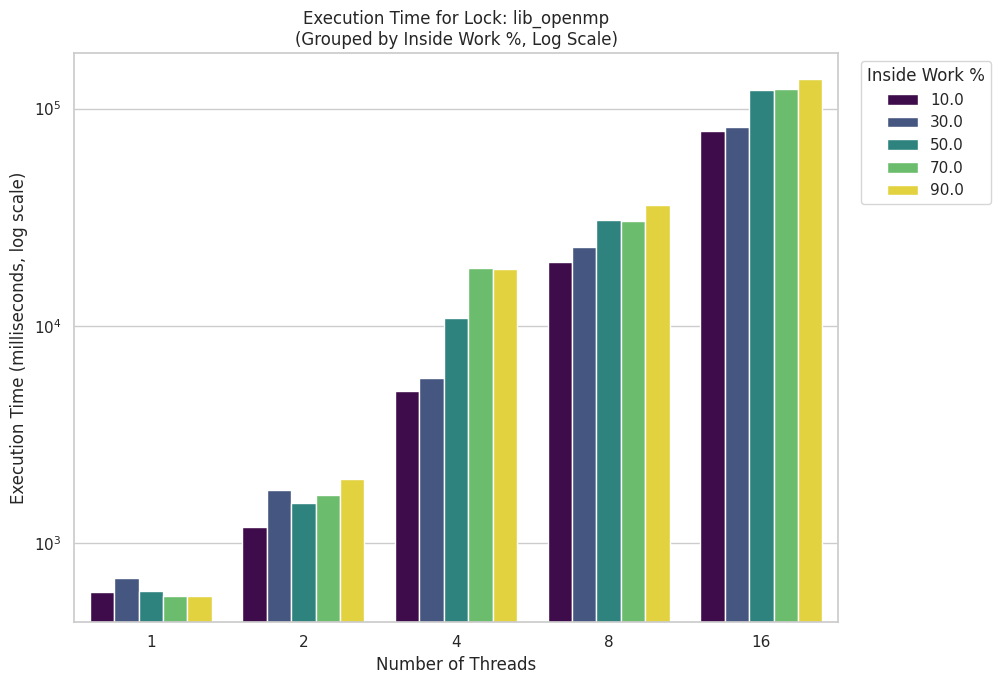

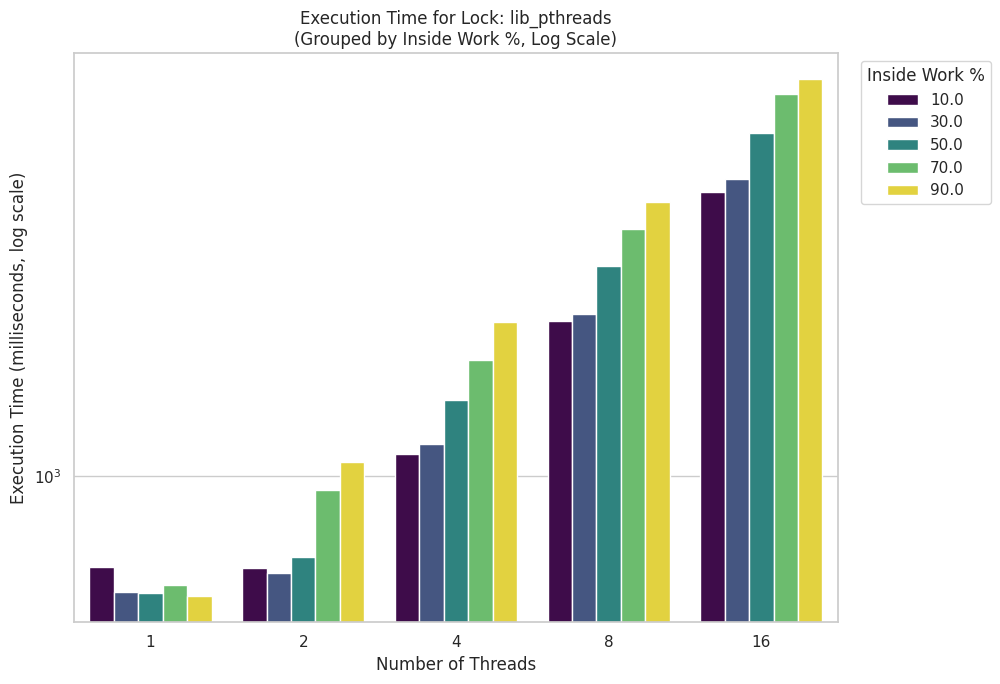

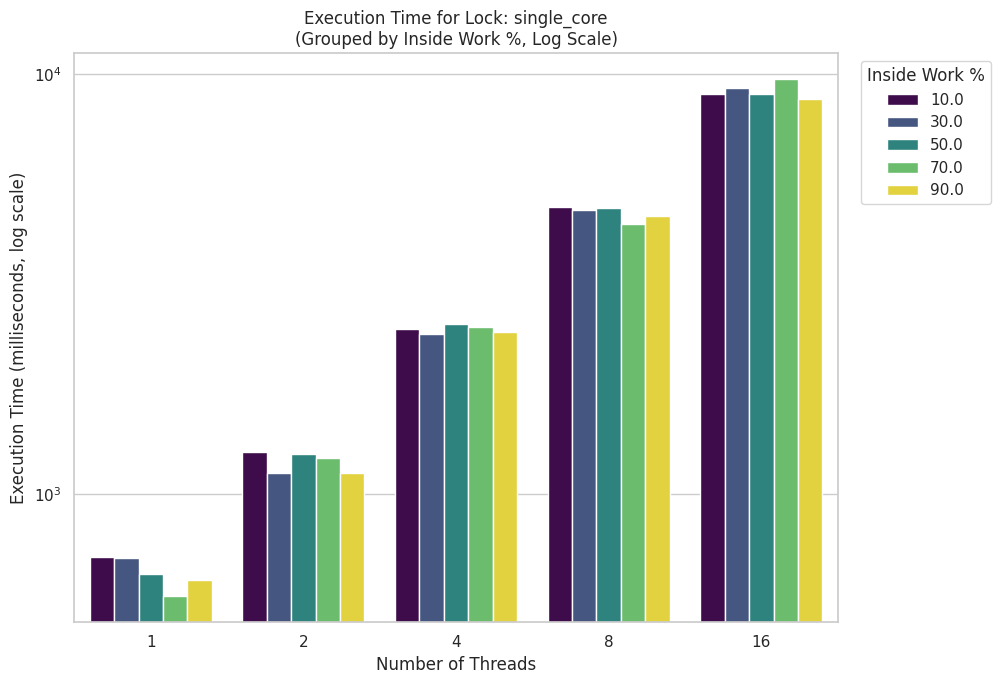

In [7]:
# --- Visualization 1: Per Lock Type (Execution Time vs Threads and Percentage) ---
print("\n--- Generating Plots: Request 1 (Per Lock Type, Log Scale) ---")
for lock_type in unique_locks:
    df_lock = performance_df[performance_df["lock_implementation"] == lock_type]
    if df_lock.empty or (df_lock["execution_time_ms"] <= 0).all():  # Skip if no positive data
        print(f"No positive data found for lock type: {lock_type}. Skipping plot.")
        continue

    plt.figure(figsize=(12, 7))
    plot = sns.barplot(
        data=df_lock[df_lock["execution_time_ms"] > 0],  # Ensure only positive values for log
        x="threads",
        y="execution_time_ms",
        hue="inside_percentage",
        palette="viridis",
    )
    # *** Add this line to set log scale ***
    plot.set_yscale("log")
    # ***************************************
    plot.set_title(f"Execution Time for Lock: {lock_type}\n(Grouped by Inside Work %, Log Scale)")
    plot.set_xlabel("Number of Threads")
    # *** Update y-label ***
    plot.set_ylabel("Execution Time (milliseconds, log scale)")
    # **********************
    plot.legend(title="Inside Work %", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()


--- Generating Plots: Request 2 (Per Thread Count, Log Scale) ---


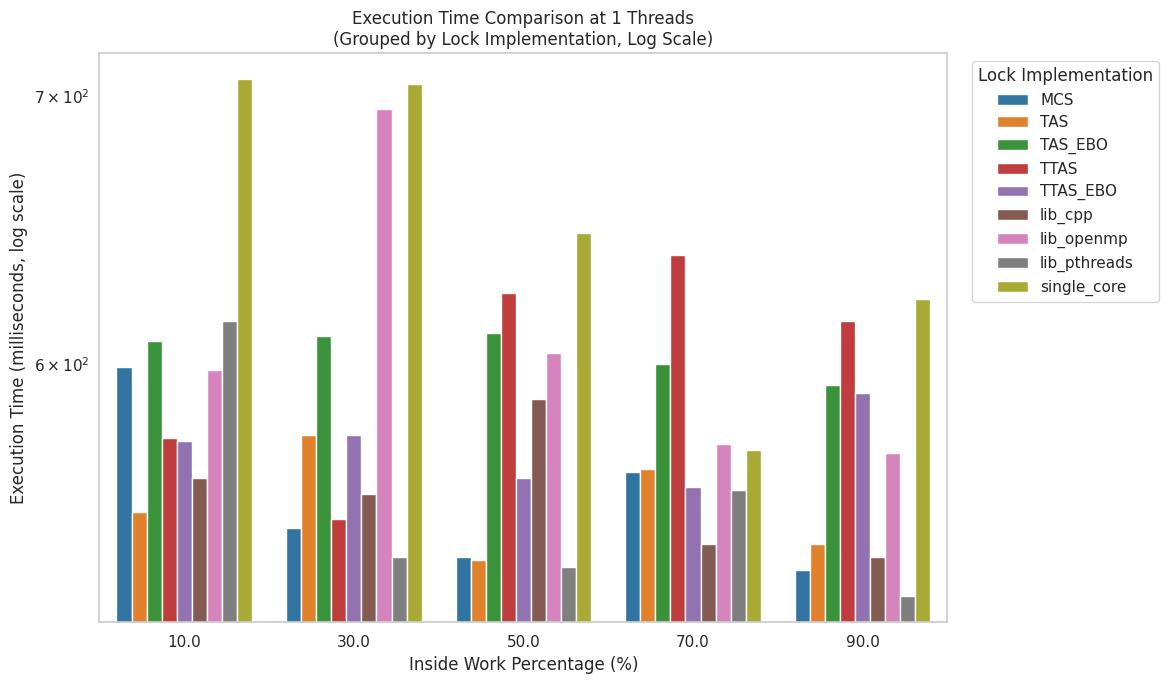

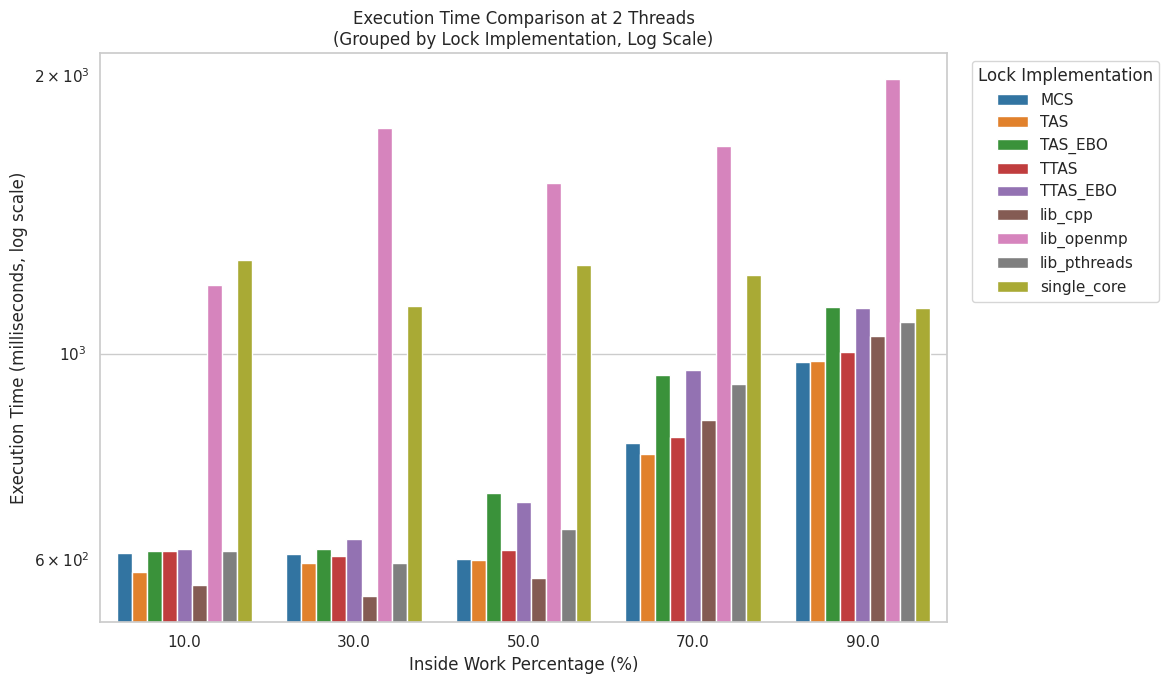

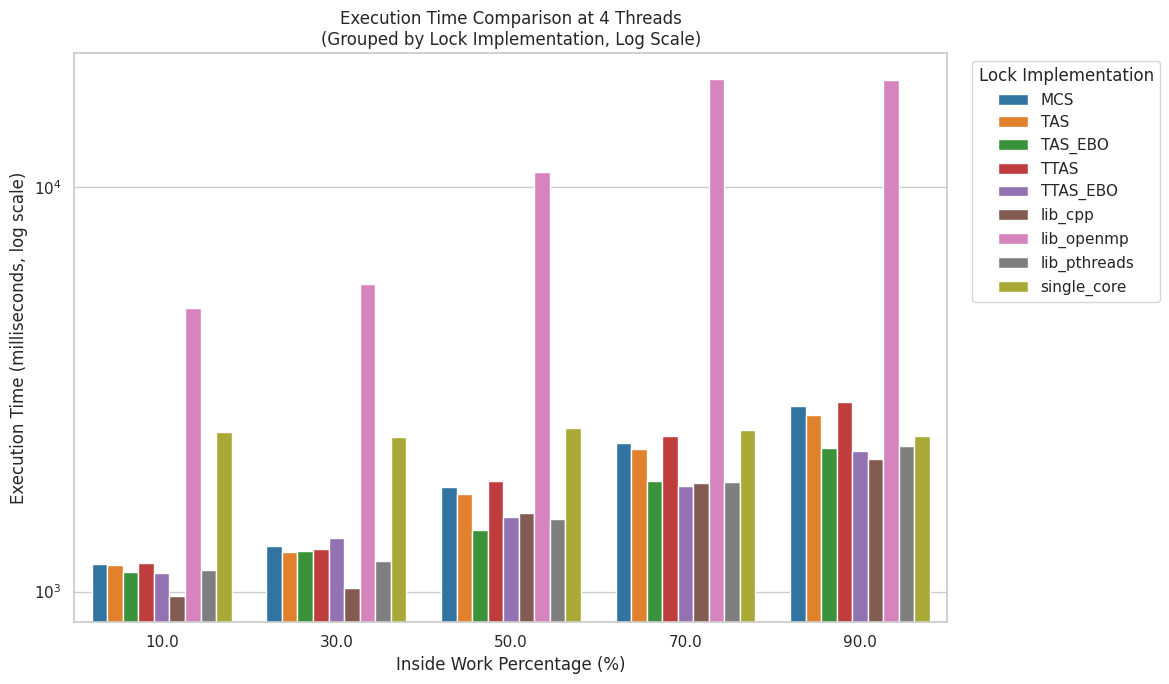

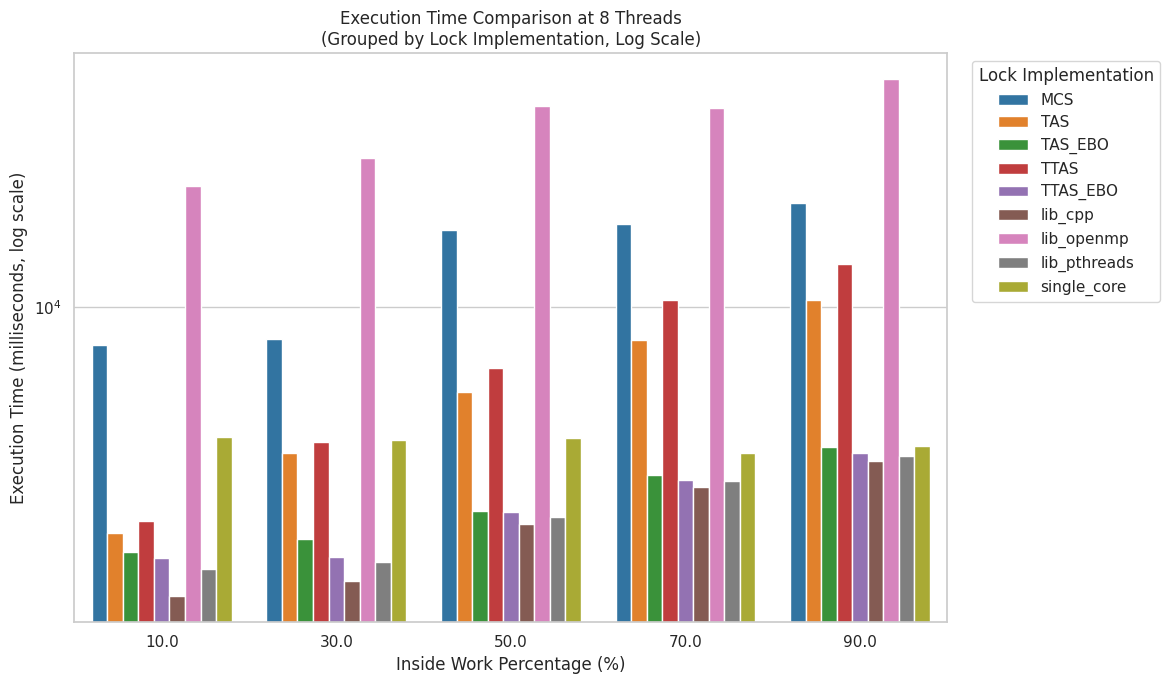

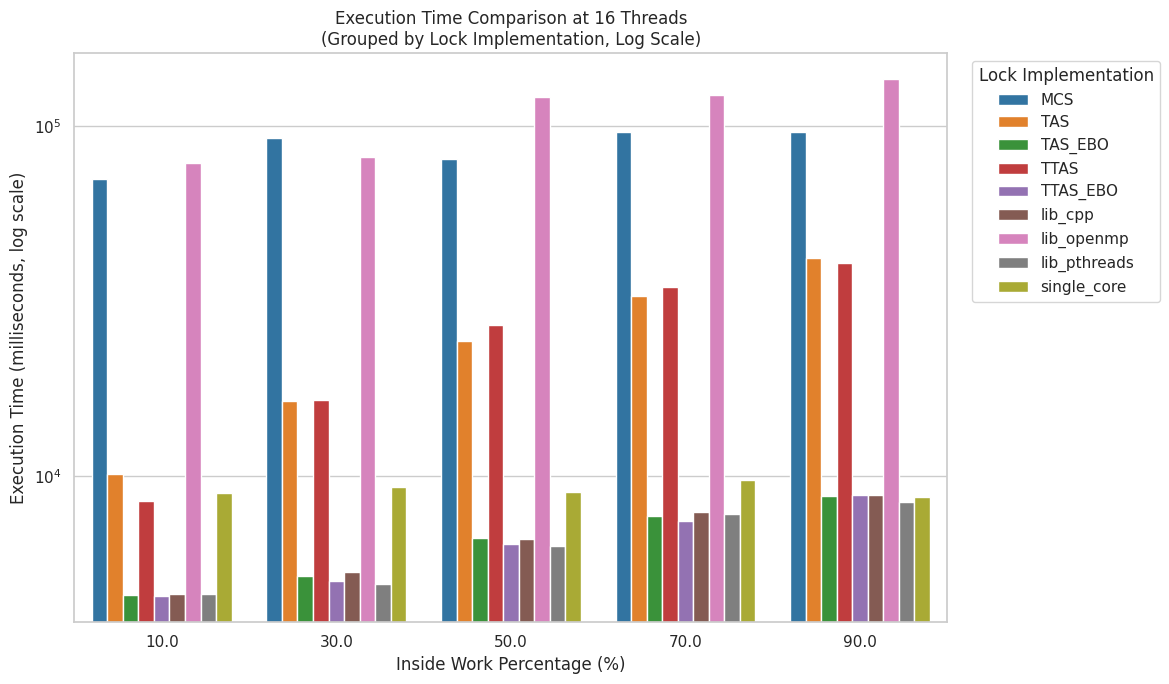

In [8]:
# --- Visualization 2: Per Thread Count (Execution Time vs Lock Type and Percentage) ---
print("\n--- Generating Plots: Request 2 (Per Thread Count, Log Scale) ---")
for thread_count in unique_threads:
    df_thread = performance_df[performance_df["threads"] == thread_count]
    if df_thread.empty or (df_thread["execution_time_ms"] <= 0).all():  # Skip if no positive data
        print(f"No positive data found for thread count: {thread_count}. Skipping plot.")
        continue

    plt.figure(figsize=(14, 7))
    plot = sns.barplot(
        data=df_thread[df_thread["execution_time_ms"] > 0],  # Ensure only positive values for log
        x="inside_percentage",
        y="execution_time_ms",
        hue="lock_implementation",
        palette="tab10",
        hue_order=unique_locks,
    )
    # *** Add this line to set log scale ***
    plot.set_yscale("log")
    # ***************************************
    plot.set_title(
        f"Execution Time Comparison at {thread_count} Threads\n(Grouped by Lock Implementation, Log Scale)"
    )
    plot.set_xlabel("Inside Work Percentage (%)")
    # *** Update y-label ***
    plot.set_ylabel("Execution Time (milliseconds, log scale)")
    # **********************
    plot.legend(title="Lock Implementation", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()


--- Generating Plots: Request 3 (Per Work Percentage, Log Scale) ---


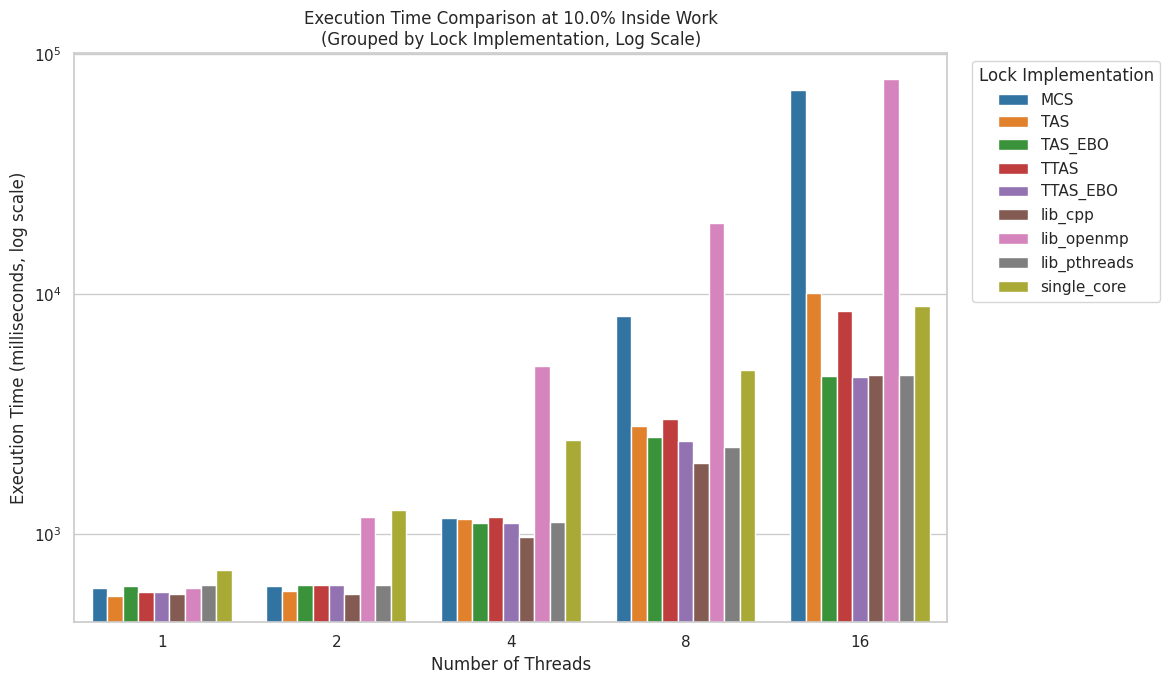

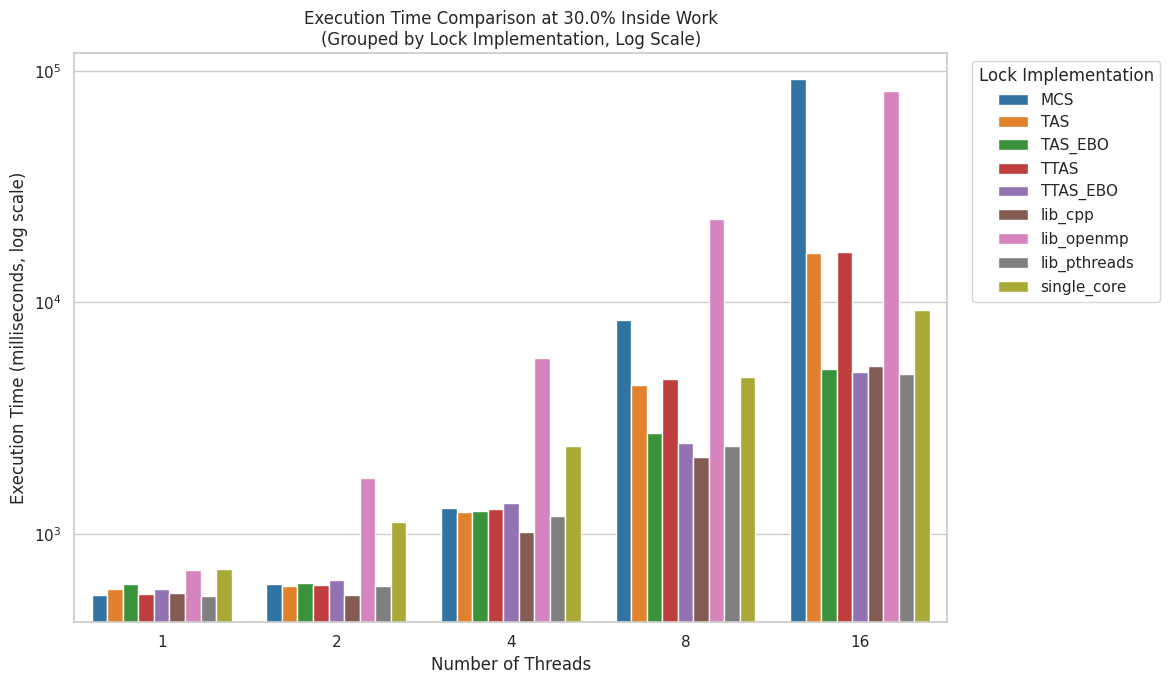

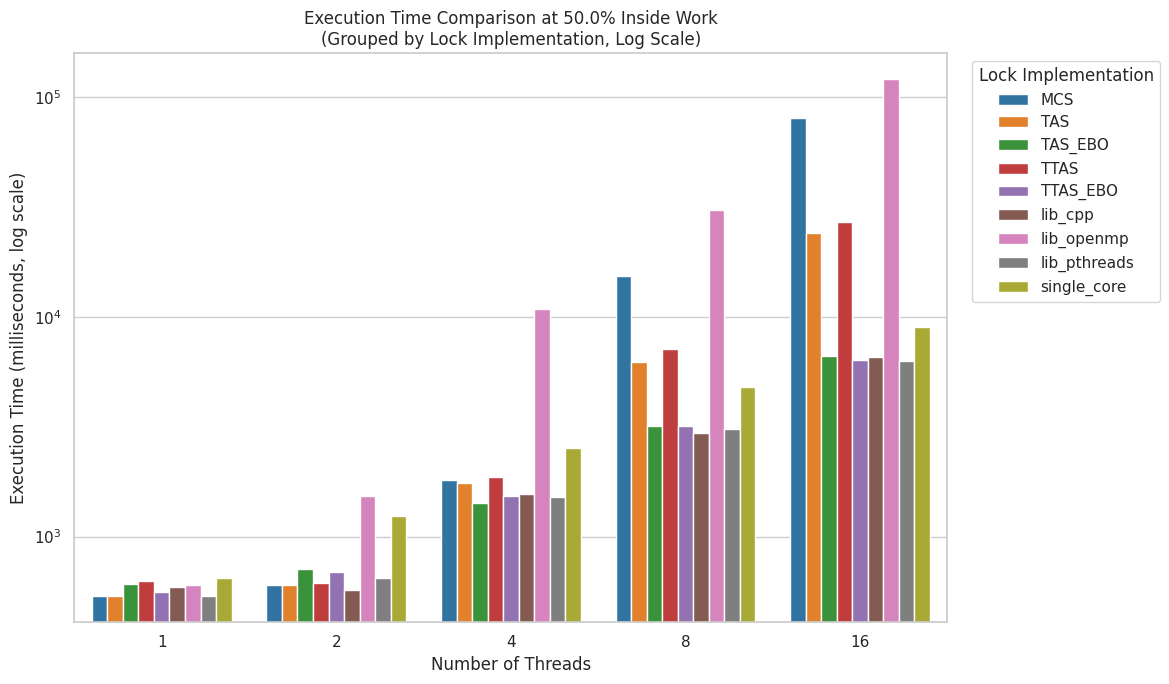

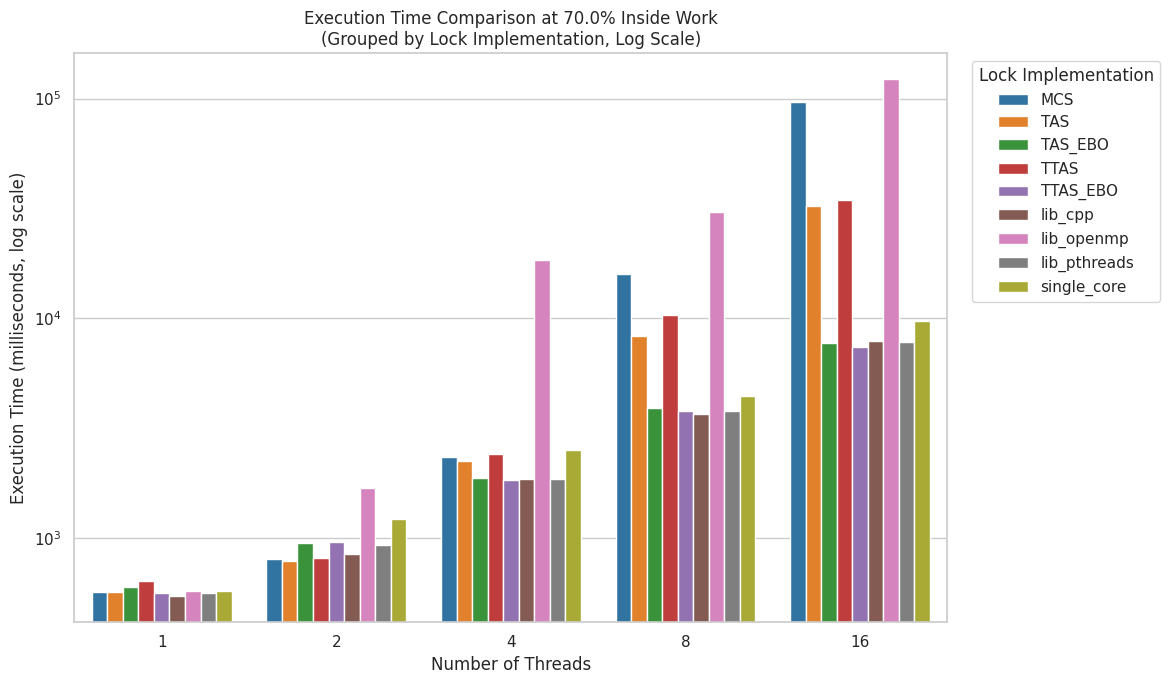

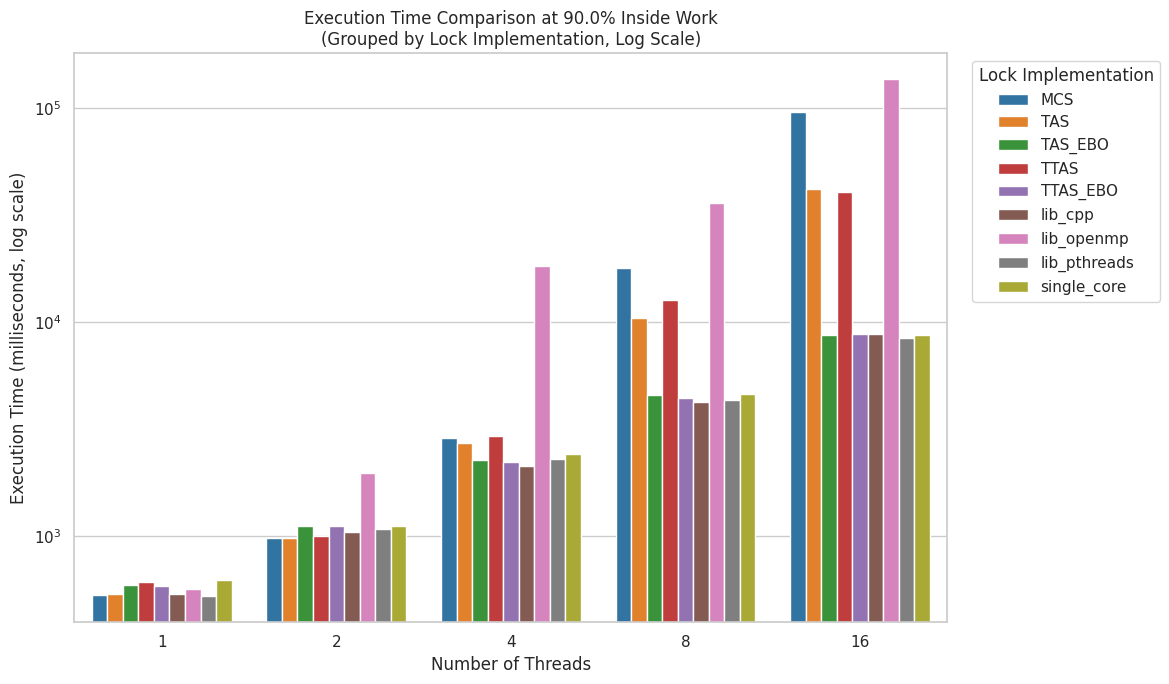


--- All plots generated (using log scale for Y-axis) ---


In [9]:
# --- Visualization 3: Per Work Percentage (Execution Time vs Lock Type and Threads) ---
print("\n--- Generating Plots: Request 3 (Per Work Percentage, Log Scale) ---")
for percentage in unique_percentages:
    df_percentage = performance_df[performance_df["inside_percentage"] == percentage]
    if (
        df_percentage.empty or (df_percentage["execution_time_ms"] <= 0).all()
    ):  # Skip if no positive data
        print(f"No positive data found for percentage: {percentage}%. Skipping plot.")
        continue

    plt.figure(figsize=(14, 7))
    plot = sns.barplot(
        data=df_percentage[
            df_percentage["execution_time_ms"] > 0
        ],  # Ensure only positive values for log
        x="threads",
        y="execution_time_ms",
        hue="lock_implementation",
        palette="tab10",
        hue_order=unique_locks,
    )
    # *** Add this line to set log scale ***
    plot.set_yscale("log")
    # ***************************************
    plot.set_title(
        f"Execution Time Comparison at {percentage}% Inside Work\n(Grouped by Lock Implementation, Log Scale)"
    )
    plot.set_xlabel("Number of Threads")
    # *** Update y-label ***
    plot.set_ylabel("Execution Time (milliseconds, log scale)")
    # **********************
    plot.legend(title="Lock Implementation", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

print("\n--- All plots generated (using log scale for Y-axis) ---")

## Other visual options

### Faceted Line Plots

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker  # Import ticker for log scale formatting
import seaborn as sns
import numpy as np
from pathlib import Path

# --- Pre-computation / Setup ---
# Make sure the DataFrame is available
if "performance_df" not in locals() or performance_df is None or performance_df.empty:
    print("Error: performance_df is not defined or is empty.")
    print("Please ensure you have run the data loading script first.")
    exit()

# Check for non-positive execution times which cause issues with log scale
if (performance_df["execution_time_ms"] <= 0).any():
    print("Warning: Found zero or negative values in 'execution_time_ms'.")
    print("These values will be excluded from log-scaled plots/axes.")
    base_plot_df = performance_df[performance_df["execution_time_ms"] > 0].copy()
else:
    base_plot_df = performance_df.copy()

if base_plot_df.empty:
    print("Error: No positive execution time data available for plotting.")
    exit()

# *** Filter out 30% and 70% inside_percentage ***
percentages_to_exclude = [30.0, 70.0]
filtered_plot_df = base_plot_df[
    ~base_plot_df["inside_percentage"].isin(percentages_to_exclude)
].copy()

if filtered_plot_df.empty:
    print(f"Error: No data remaining after excluding percentages {percentages_to_exclude}.")
    exit()
# **************************************************


# Improve plot aesthetics (optional)
sns.set_theme(style="whitegrid")

# Get unique values FROM THE FILTERED DATA for iteration (ensure consistent ordering)
unique_locks = sorted(filtered_plot_df["lock_implementation"].unique())
unique_threads = sorted(filtered_plot_df["threads"].unique())
unique_percentages = sorted(filtered_plot_df["inside_percentage"].unique())  # Use filtered data

print(f"Plotting with Locks: {unique_locks}")
print(f"Plotting with Thread Counts: {unique_threads}")
print(f"Plotting with Inside Percentages: {unique_percentages}")  # Should not contain 30 or 70

Plotting with Locks: ['MCS', 'TAS', 'TAS_EBO', 'TTAS', 'TTAS_EBO', 'lib_cpp', 'lib_openmp', 'lib_pthreads', 'single_core']
Plotting with Thread Counts: [np.int64(1), np.int64(2), np.int64(4), np.int64(8), np.int64(16)]
Plotting with Inside Percentages: [np.float64(10.0), np.float64(50.0), np.float64(90.0)]



--- Generating Plot: Option 1 (Faceted Line Plot - Modified) ---


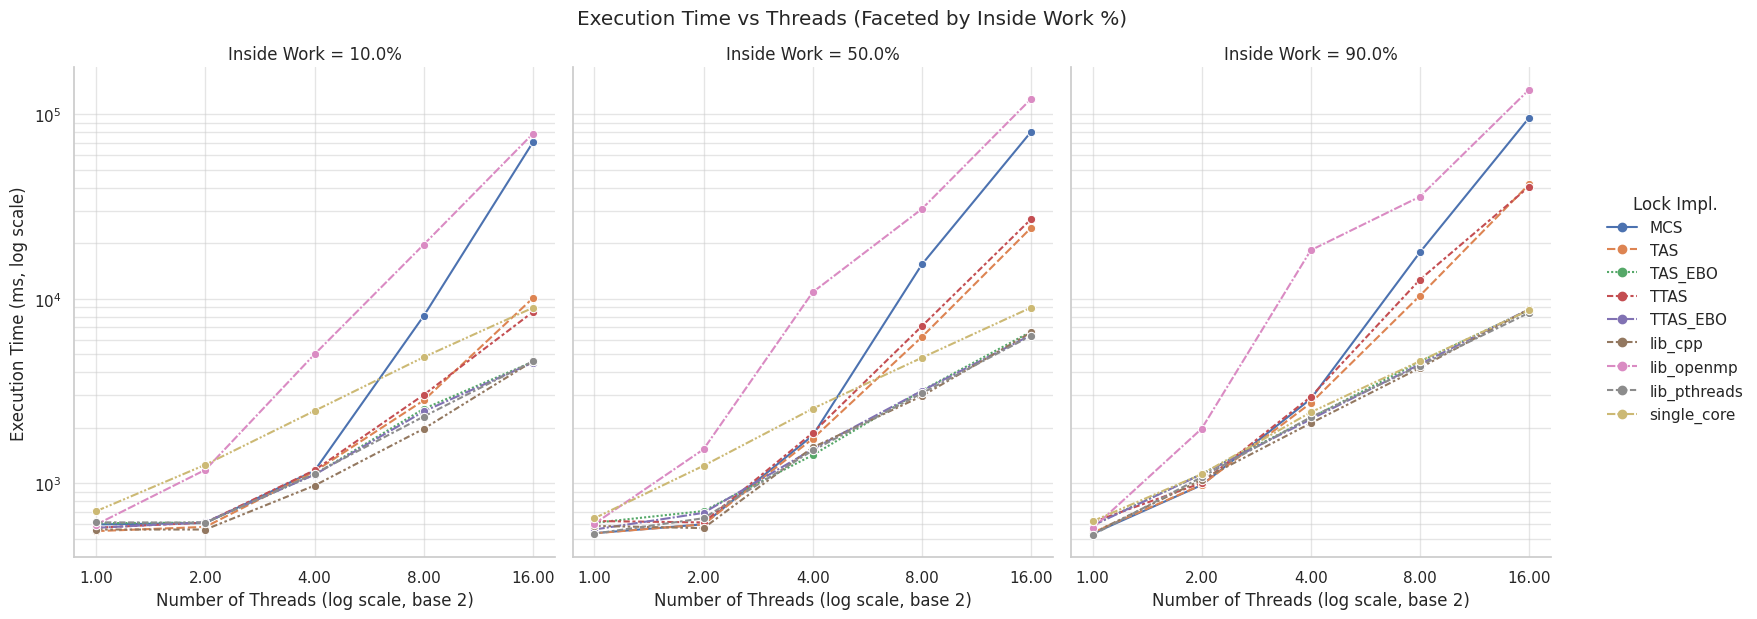

In [11]:
# --- Option 1: Faceted Line Plots (Modified) ---
print("\n--- Generating Plot: Option 1 (Faceted Line Plot - Modified) ---")

# Use seaborn's relplot to create faceted line plots
# Increase height for a larger plot
g1 = sns.relplot(
    data=filtered_plot_df,  # *** Use filtered data ***
    kind="line",
    x="threads",
    y="execution_time_ms",
    hue="lock_implementation",
    hue_order=unique_locks,
    col="inside_percentage",
    col_order=unique_percentages,  # Use updated list
    style="lock_implementation",
    style_order=unique_locks,
    marker="o",
    height=6,  # *** Increased height for larger facets ***
    aspect=0.9,  # Adjust aspect ratio if needed
)

# Apply log scale to BOTH x and y axes of each facet
for ax in g1.axes.flat:
    ax.set_yscale("log")
    ax.set_xscale("log", base=2)  # *** Set x-axis to log scale (base 2) ***

    # --- Optional: Format log ticks ---
    # Y-axis (base 10 is usually fine, default formatter works well)
    ax.grid(True, which="both", ls="-", alpha=0.5)  # Grid for both major/minor ticks

    # X-axis (use base 2 ticks since threads are likely powers of 2)
    # Ensure ticks appear at thread counts like 1, 2, 4, 8, 16
    ax.xaxis.set_major_locator(
        ticker.LogLocator(base=2.0, numticks=10)
    )  # Adjust numticks as needed
    # Make sure labels are standard numbers (e.g., '16' not '2^4')
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    # Optional: Prevent minor ticks if too cluttered
    # ax.xaxis.set_minor_locator(ticker.NullLocator())
    # --- End Optional Tick Formatting ---


# Adjust titles and labels
g1.fig.suptitle("Execution Time vs Threads (Faceted by Inside Work %)", y=1.03)
# *** Update axis labels for log scale ***
g1.set_axis_labels("Number of Threads (log scale, base 2)", "Execution Time (ms, log scale)")
# ***************************************
g1.set_titles("Inside Work = {col_name}%")
g1.legend.set_title("Lock Impl.")

# Improve layout
# plt.tight_layout()
plt.show()

### Heatmaps

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors  # Needed for LogNorm in heatmap
import seaborn as sns
import numpy as np  # For log calculation if needed and checking positivity
from pathlib import Path

# --- Pre-computation / Setup ---
# Make sure the DataFrame is available
if "performance_df" not in locals() or performance_df is None or performance_df.empty:
    print("Error: performance_df is not defined or is empty.")
    print("Please ensure you have run the data loading script first.")
    exit()

# Check for non-positive execution times which cause issues with log scale
if (performance_df["execution_time_ms"] <= 0).any():
    print("Warning: Found zero or negative values in 'execution_time_ms'.")
    print("These values will be excluded from log-scaled plots/axes.")
    # Filter data for plots that need strictly positive values
    plot_df = performance_df[performance_df["execution_time_ms"] > 0].copy()
else:
    plot_df = performance_df.copy()

if plot_df.empty:
    print("Error: No positive execution time data available for plotting.")
    exit()

# Improve plot aesthetics (optional)
sns.set_theme(style="whitegrid")

# Get unique values for iteration (ensure consistent ordering)
unique_locks = sorted(plot_df["lock_implementation"].unique())
unique_threads = sorted(plot_df["threads"].unique())
unique_percentages = sorted(plot_df["inside_percentage"].unique())

print(f"Plotting with Locks: {unique_locks}")
print(f"Plotting with Thread Counts: {unique_threads}")
print(f"Plotting with Inside Percentages: {unique_percentages}")

Plotting with Locks: ['MCS', 'TAS', 'TAS_EBO', 'TTAS', 'TTAS_EBO', 'lib_cpp', 'lib_openmp', 'lib_pthreads', 'single_core']
Plotting with Thread Counts: [np.int64(1), np.int64(2), np.int64(4), np.int64(8), np.int64(16)]
Plotting with Inside Percentages: [np.float64(10.0), np.float64(30.0), np.float64(50.0), np.float64(70.0), np.float64(90.0)]



--- Generating Plots: Option 2 (Heatmaps) ---


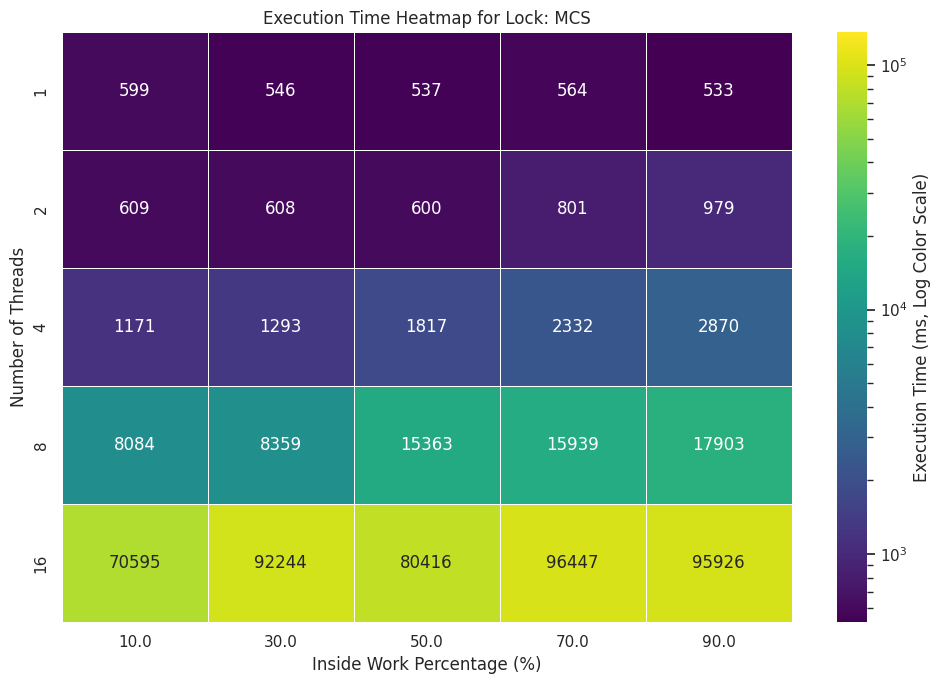

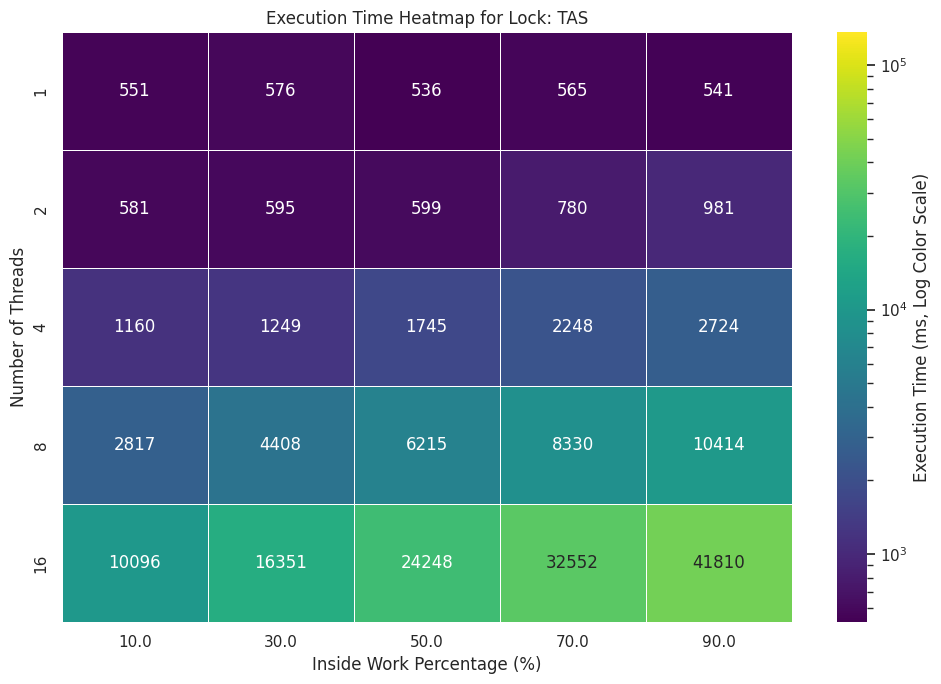

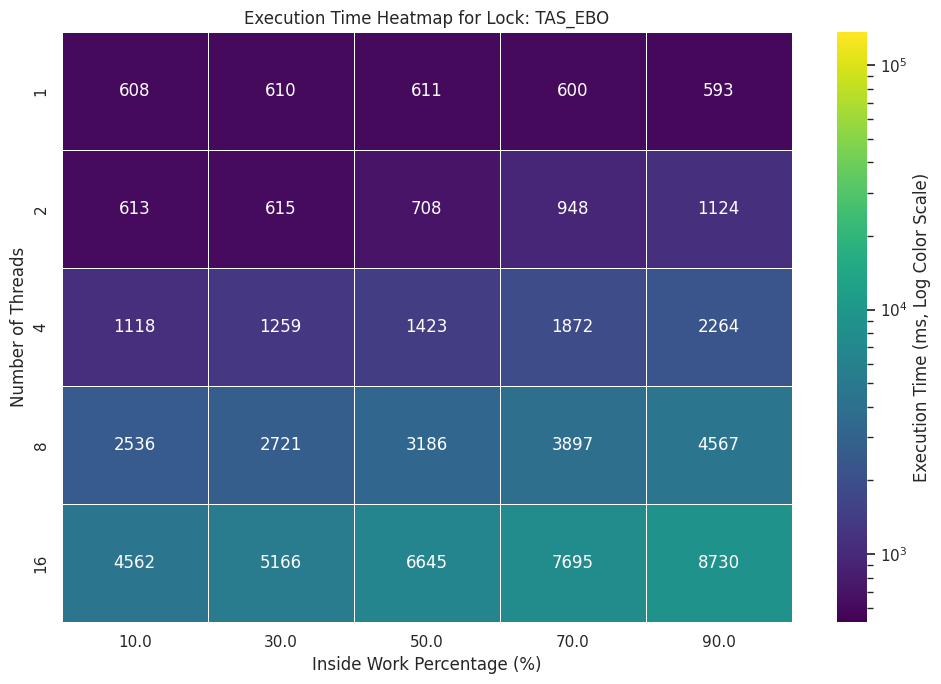

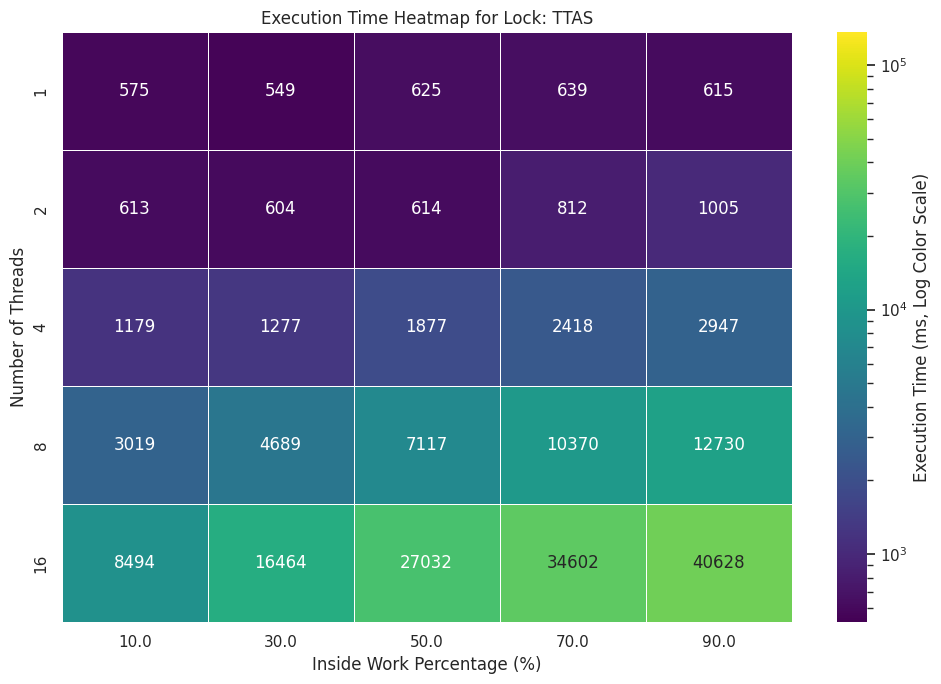

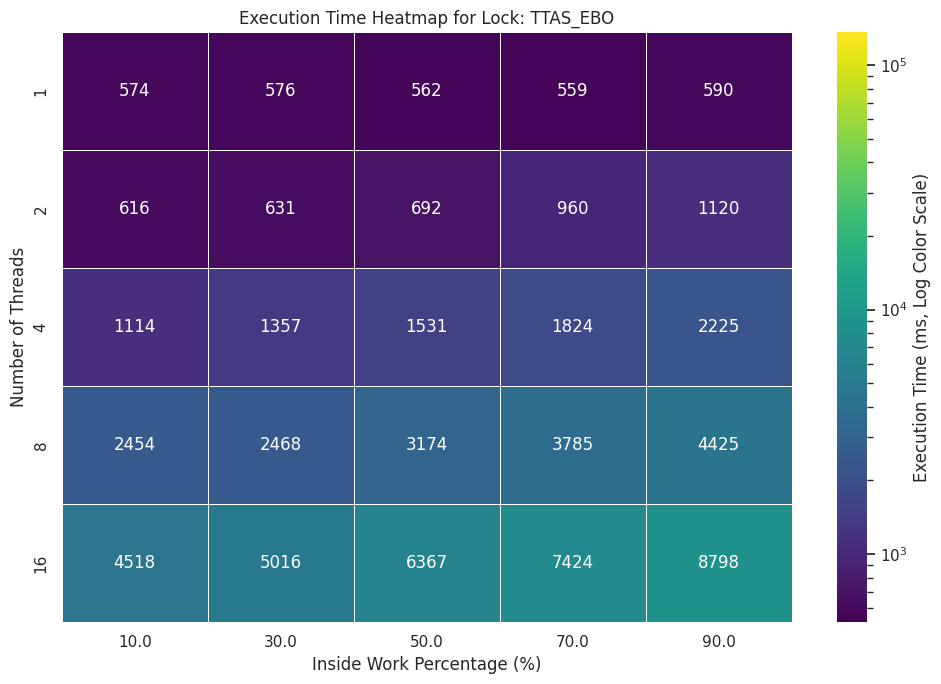

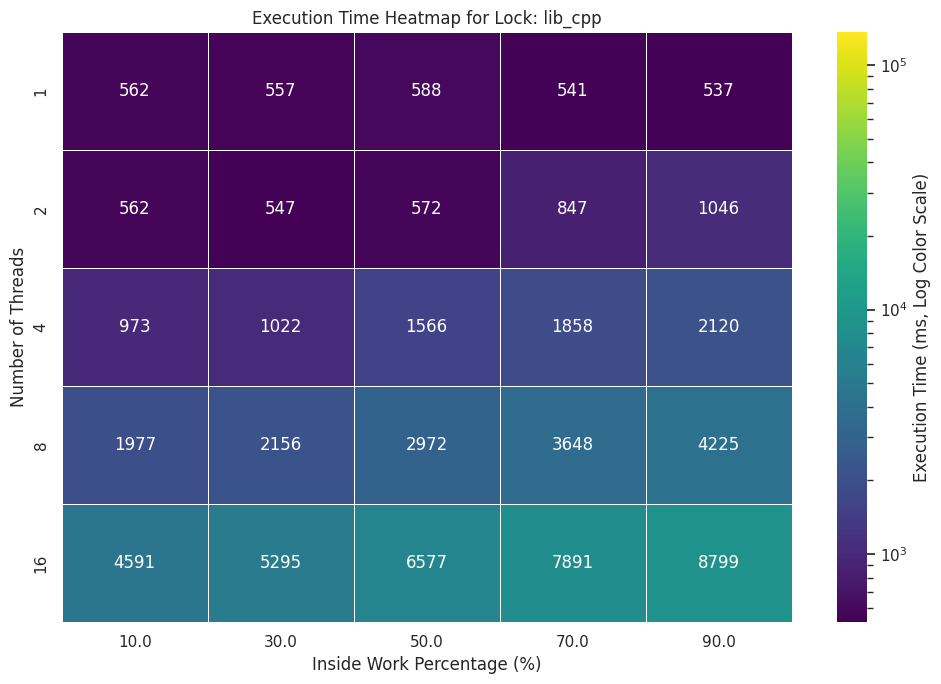

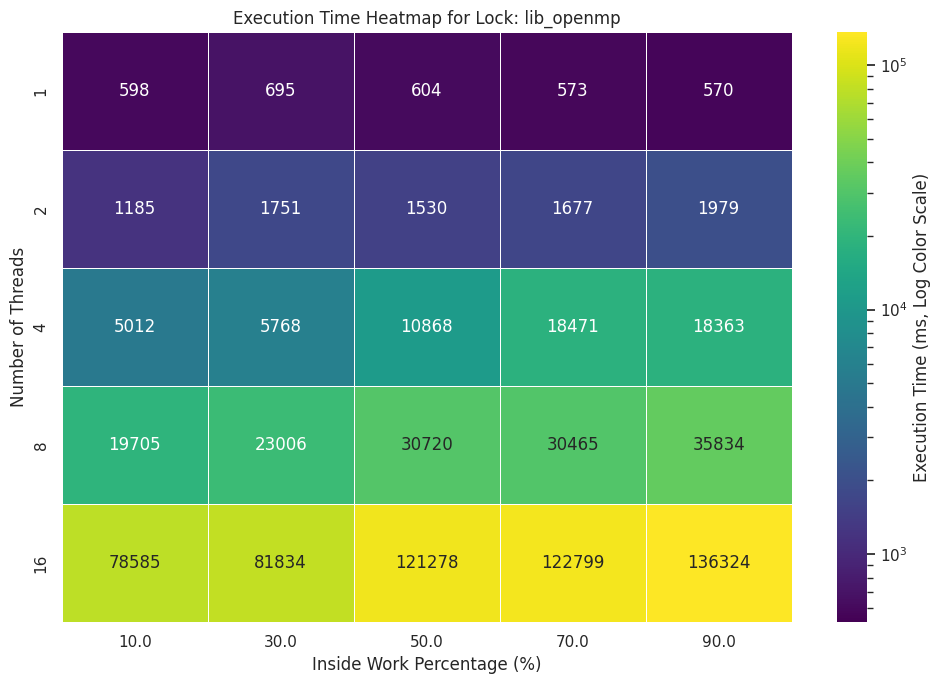

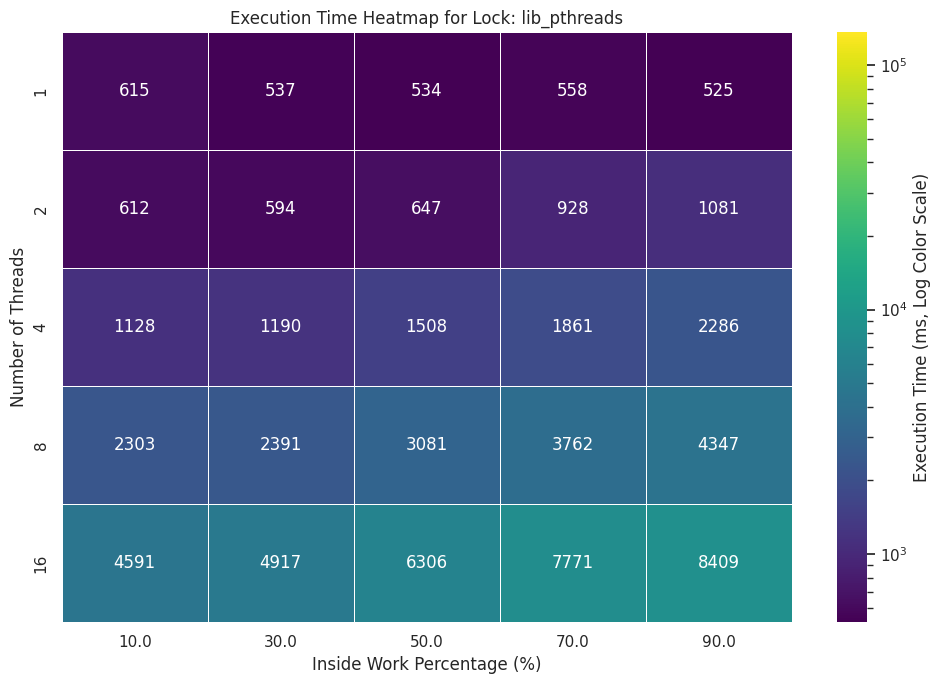

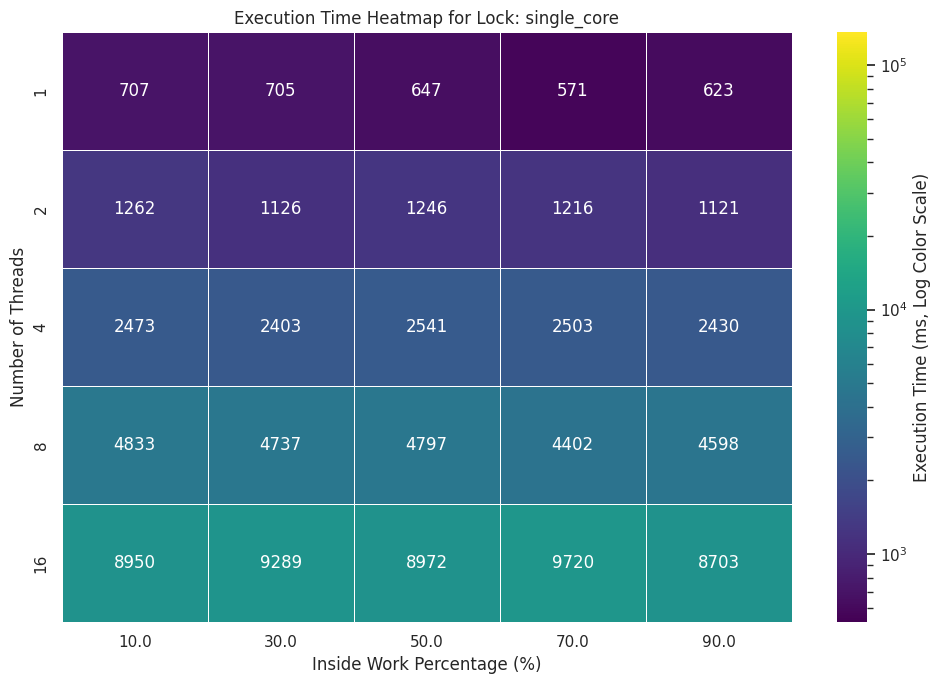


--- All alternative plots generated ---


In [13]:
# --- Option 2: Heatmaps (One per Lock Implementation) ---
print("\n--- Generating Plots: Option 2 (Heatmaps) ---")

# Determine the overall min/max execution time across positive values for consistent color mapping
vmin = plot_df["execution_time_ms"].min()
vmax = plot_df["execution_time_ms"].max()

# Create a separate heatmap for each lock implementation
for lock_type in unique_locks:
    df_lock = plot_df[plot_df["lock_implementation"] == lock_type]

    if df_lock.empty:
        print(f"No positive data for lock type: {lock_type}. Skipping heatmap.")
        continue

    try:
        # Pivot the data for the heatmap
        pivot_data = df_lock.pivot_table(
            values="execution_time_ms", index="threads", columns="inside_percentage"
        )

        # Ensure columns (percentages) are sorted correctly if pivot_table didn't
        pivot_data = pivot_data.reindex(columns=unique_percentages)
        # Ensure rows (threads) are sorted correctly if pivot_table didn't
        pivot_data = pivot_data.reindex(index=unique_threads)

        if pivot_data.empty:
            print(f"Pivot table empty for lock type: {lock_type}. Skipping heatmap.")
            continue

        # Create the plot
        plt.figure(figsize=(10, 7))  # Adjust size as needed
        ax = sns.heatmap(
            pivot_data,
            annot=True,  # Show values in cells
            fmt=".0f",  # Format annotation values (0 decimal places for ms)
            linewidths=0.5,
            cmap="viridis",  # Or choose another like 'rocket', 'magma'
            # Use LogNorm for color scaling - handles wide range well
            norm=mcolors.LogNorm(vmin=vmin, vmax=vmax),
            cbar_kws={"label": "Execution Time (ms, Log Color Scale)"},  # Label for the color bar
        )
        ax.set_title(f"Execution Time Heatmap for Lock: {lock_type}")
        ax.set_xlabel("Inside Work Percentage (%)")
        ax.set_ylabel("Number of Threads")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Could not generate heatmap for {lock_type}: {e}")


print("\n--- All alternative plots generated ---")

# Visualize speed up

## Load data and Prepare Baselines

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
from pathlib import Path

# --- Load Data ---
# Make sure your loading function includes 'perf_single_core' results
# And that the 'lock_implementation' column is correctly populated ('single_core' for baseline)

# Example using the previous function (ensure it's defined or pasted)
# def load_performance_data(base_directory: Path) -> pd.DataFrame | None:
#     # ... (loading function definition) ...
#     pass
# results_dir = Path('.')
# performance_df = load_performance_data(results_dir)

# Ensure DataFrame is loaded
if "performance_df" not in locals() or performance_df is None or performance_df.empty:
    print("Error: performance_df is not defined or is empty.")
    print("Ensure it's loaded and includes 'single_core' results.")
    exit()

# Check if 'single_core' data exists
if "single_core" not in performance_df["lock_implementation"].unique():
    print("Error: Baseline 'single_core' data not found in the DataFrame.")
    print("Please ensure the 'perf_single_core' directory was processed correctly.")
    exit()

# --- Prepare Baselines ---

# Define columns that identify a unique configuration run
# IMPORTANT: Verify these are the correct columns to match baseline with parallel runs
config_cols = [
    "threads",
    "iterations",
    "inside_work",
    "outside_work",
    "inside_percentage",
    "check_target",
]

# Separate single-core (baseline) and parallel data
baseline_df = performance_df[performance_df["lock_implementation"] == "single_core"].copy()
parallel_df = performance_df[performance_df["lock_implementation"] != "single_core"].copy()

# Check for issues in baseline data (e.g., duplicate configs)
duplicate_configs = baseline_df[baseline_df.duplicated(subset=config_cols, keep=False)]
if not duplicate_configs.empty:
    print("Warning: Found duplicate configurations in the baseline (single_core) data.")
    print(duplicate_configs)
    # Decide how to handle: maybe take the mean, or first/last? Taking mean for now.
    baseline_df = baseline_df.groupby(config_cols, as_index=False)["execution_time_ms"].mean()
    print("-> Aggregated duplicates by taking the mean execution time.")


# Create a baseline lookup structure (using a multi-index Series)
# Set the configuration columns as the index for easy lookup
baseline_times = baseline_df.set_index(config_cols)["execution_time_ms"]

# Check if baseline times were extracted
if baseline_times.empty:
    print("Error: Failed to extract baseline times.")
    exit()

print(f"Extracted {len(baseline_times)} unique baseline configurations.")
# print("\nBaseline Times Index Sample:")
# print(baseline_times.head())

Extracted 25 unique baseline configurations.


## Calculate speed up

In [15]:
# --- Calculate Speedup ---


def calculate_speedup(row, baseline_lookup, config_cols):
    """Calculates speedup for a given parallel run row."""
    # Create the index tuple from the row's config values
    lookup_key = tuple(row[col] for col in config_cols)

    try:
        baseline_time = baseline_lookup.loc[lookup_key]
        parallel_time = row["execution_time_ms"]

        # Avoid division by zero or using non-positive times
        if (
            parallel_time is not None
            and parallel_time > 0
            and baseline_time is not None
            and baseline_time > 0
        ):
            return baseline_time / parallel_time
        else:
            return np.nan  # Not applicable if times are invalid
    except KeyError:
        # Corresponding baseline configuration not found
        # print(f"Warning: Baseline not found for config: {lookup_key}") # Can be noisy
        return np.nan  # Indicate missing baseline
    except Exception as e:
        print(f"Error during lookup for {lookup_key}: {e}")
        return np.nan


print("\nCalculating speedup...")
# Apply the function to each row of the parallel data
parallel_df["speedup"] = parallel_df.apply(
    lambda row: calculate_speedup(row, baseline_times, config_cols), axis=1
)

# Check results
missing_speedup_count = parallel_df["speedup"].isna().sum()
if missing_speedup_count > 0:
    print(
        f"Warning: Could not calculate speedup for {missing_speedup_count} rows (likely missing baseline)."
    )

# Remove rows where speedup couldn't be calculated for plotting
speedup_plot_df = parallel_df.dropna(subset=["speedup"]).copy()

if speedup_plot_df.empty:
    print("Error: No valid speedup data available for plotting after calculation.")
    exit()

print(f"Successfully calculated speedup for {len(speedup_plot_df)} rows.")
# print("\nSpeedup Data Sample:")
# print(speedup_plot_df[['lock_implementation', 'threads', 'inside_percentage', 'execution_time_ms', 'speedup']].head())


Calculating speedup...
Successfully calculated speedup for 200 rows.


## Plot


Generating Speedup Plots (without Ideal Speedup line)...
 Plotting: Request 1 (Per Lock Type)


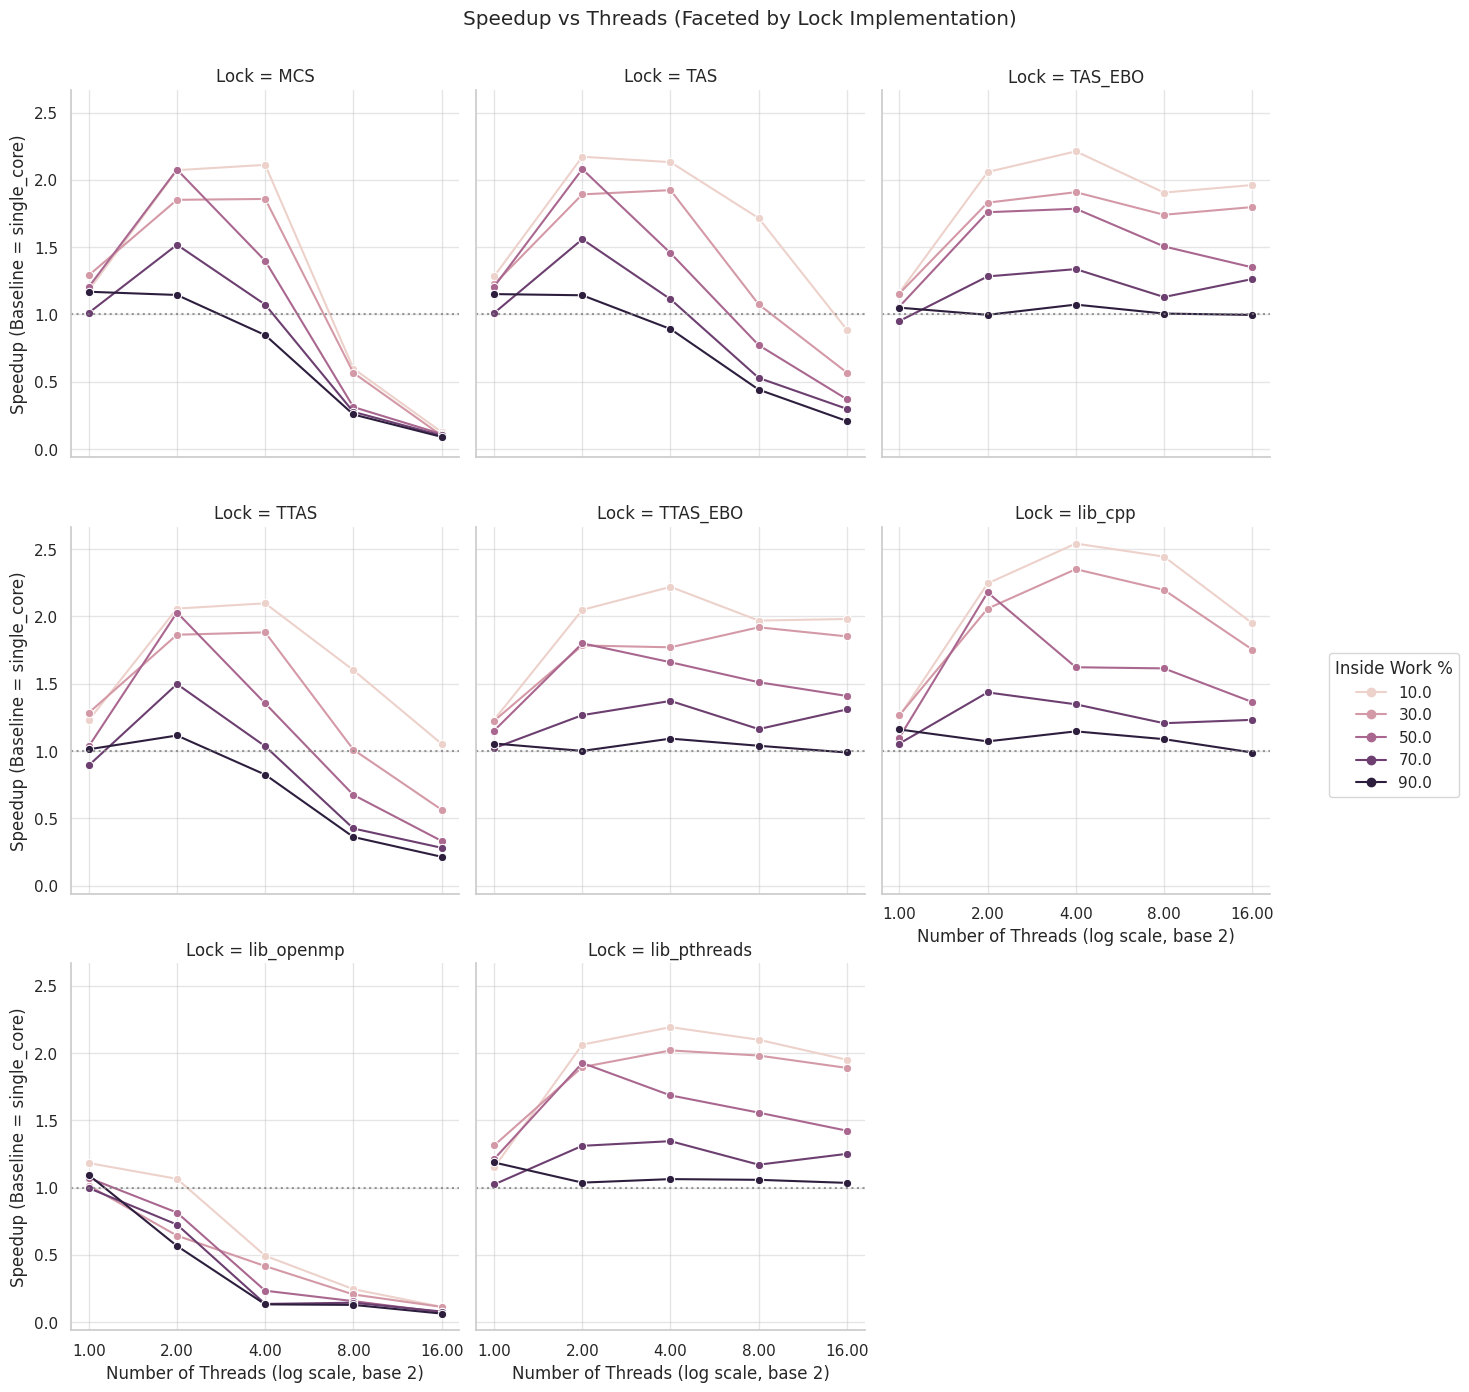

 Plotting: Request 2 (Per Thread Count)


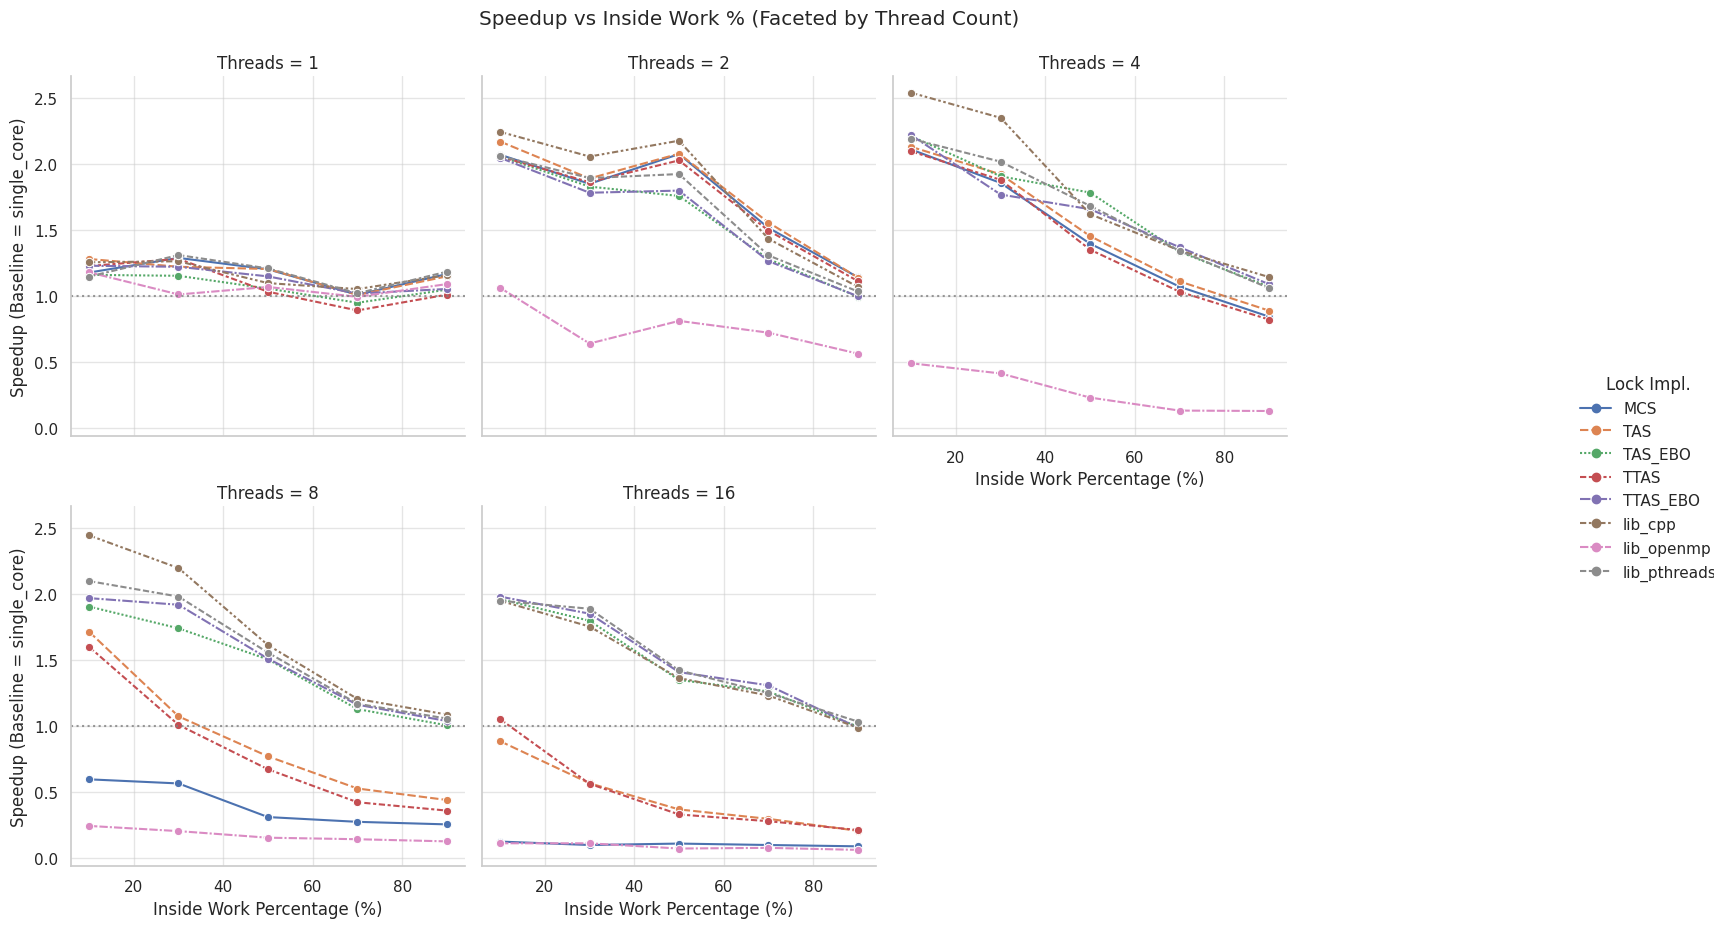

 Plotting: Request 3 (Per Work Percentage)


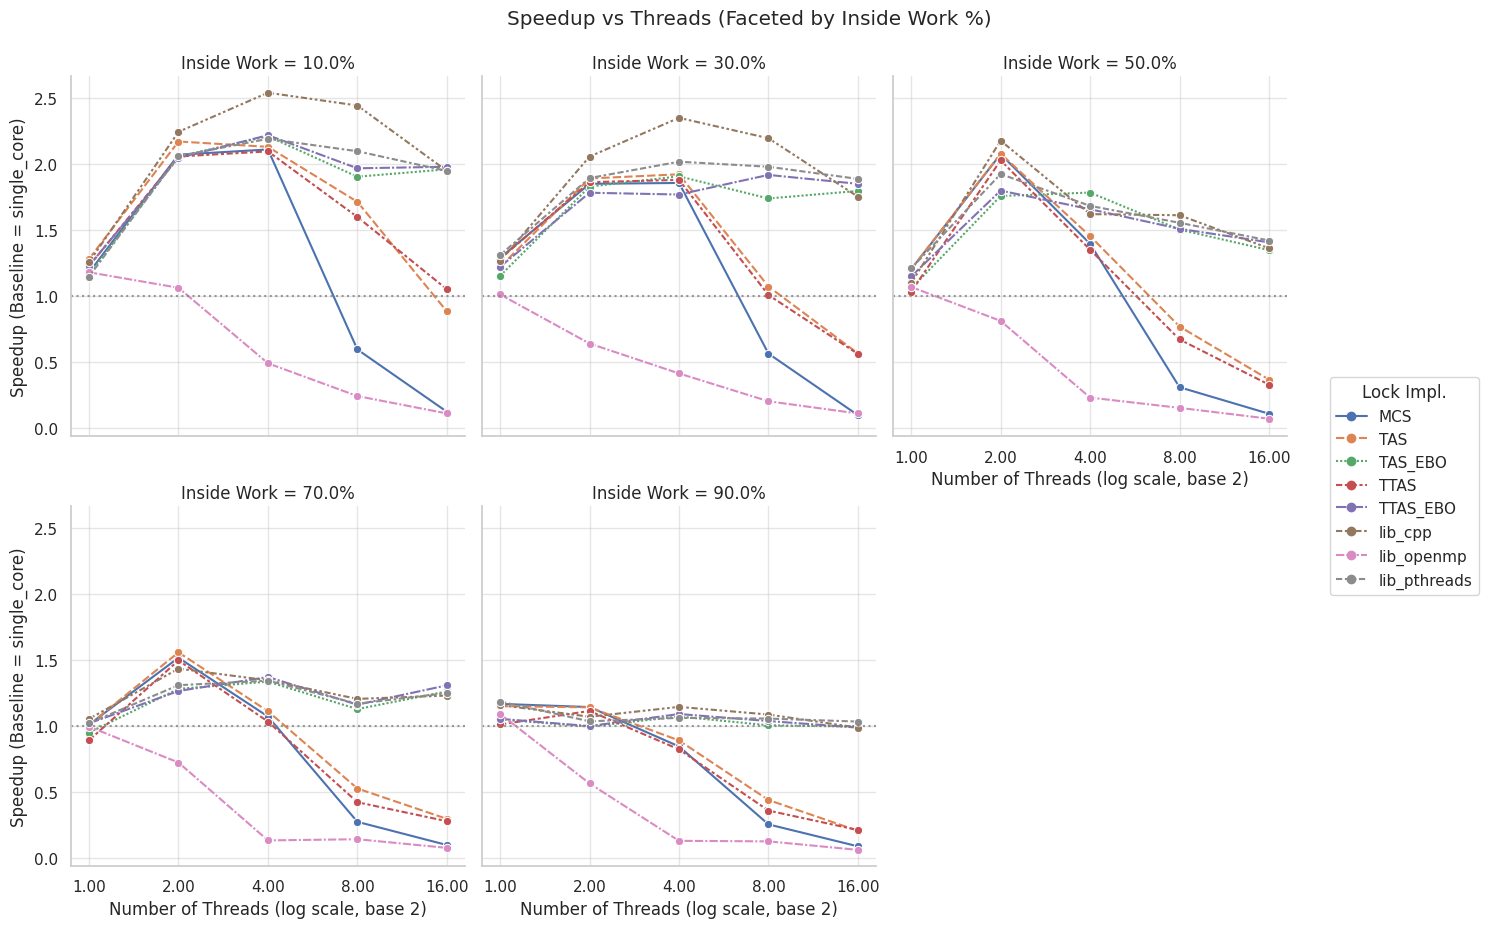


--- Speedup plots generated (without Ideal Speedup line) ---


In [16]:
# --- Setup for Visualization ---
viz_locks = sorted(speedup_plot_df["lock_implementation"].unique())
viz_threads = sorted(speedup_plot_df["threads"].unique())
viz_percentages = sorted(speedup_plot_df["inside_percentage"].unique())

sns.set_theme(style="whitegrid")
print("\nGenerating Speedup Plots (without Ideal Speedup line)...")


# --- Visualization 1: Speedup per Lock Type (No Ideal Line) ---
print(" Plotting: Request 1 (Per Lock Type)")
g1 = sns.relplot(
    data=speedup_plot_df,
    kind="line",
    x="threads",
    y="speedup",  # Plot speedup
    hue="inside_percentage",  # Group by percentage within each plot
    hue_order=viz_percentages,
    col="lock_implementation",  # Facet by lock type
    col_order=viz_locks,
    col_wrap=3,
    marker="o",
    height=4.5,
    aspect=1,
)

# Adjust axes (No ideal line plotting here)
for ax in g1.axes.flat:
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_locator(ticker.LogLocator(base=2.0, numticks=10))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.grid(True, which="both", ls="-", alpha=0.5)
    # Add horizontal line at y=1 (no speedup) for reference
    ax.axhline(1.0, ls=":", color="grey", alpha=0.8)

# Adjust legend (No ideal line entry)
# Remove the default facet grid legend if it exists
if g1.legend is not None:
    g1.legend.remove()
# Recreate figure-level legend without ideal line data
handles, labels = g1.axes.flat[0].get_legend_handles_labels()
# Filter out any potentially empty handles/labels if relplot added some unexpectedly
filtered_handles = [h for h, l in zip(handles, labels) if l]
filtered_labels = [l for l in labels if l]

if filtered_handles:  # Only add legend if there are actual lines plotted
    g1.fig.legend(
        handles=filtered_handles,
        labels=filtered_labels,
        title="Inside Work %",
        loc="center right",
        bbox_to_anchor=(0.98, 0.5),
    )  # Adjust position
    plt.subplots_adjust(right=0.85)  # Leave space for legend
else:
    print("Warning: No legend items found for Plot 1.")


# Set titles
g1.fig.suptitle("Speedup vs Threads (Faceted by Lock Implementation)", y=1.03)
g1.set_axis_labels("Number of Threads (log scale, base 2)", "Speedup (Baseline = single_core)")
g1.set_titles("Lock = {col_name}")

plt.show()


# --- Visualization 2: Speedup per Thread Count (No Ideal Line) ---
print(" Plotting: Request 2 (Per Thread Count)")
g2 = sns.relplot(
    data=speedup_plot_df,
    kind="line",
    x="inside_percentage",  # Percentage on X-axis
    y="speedup",
    hue="lock_implementation",  # Compare locks within plot
    hue_order=viz_locks,
    style="lock_implementation",  # Different line styles
    style_order=viz_locks,
    col="threads",  # Facet by thread count
    col_order=viz_threads,
    col_wrap=3,
    marker="o",
    height=4.5,
    aspect=1,
)
# Adjust axes (No ideal line plotting here)
for ax in g2.axes.flat:
    ax.grid(True, which="both", ls="-", alpha=0.5)
    # Add horizontal line at y=1 (no speedup)
    ax.axhline(1.0, ls=":", color="grey", alpha=0.8)

g2.fig.suptitle("Speedup vs Inside Work % (Faceted by Thread Count)", y=1.03)
g2.set_axis_labels("Inside Work Percentage (%)", "Speedup (Baseline = single_core)")
g2.set_titles("Threads = {col_name}")

# Move legend (No ideal line entry)
if g2.legend is not None:
    # Check if there are handles before trying to move legend
    handles, labels = g2.axes.flat[0].get_legend_handles_labels()
    if any(l for l in labels):  # Check if there are any non-empty labels
        plt.subplots_adjust(right=0.85)
        g2.legend.set_bbox_to_anchor((1.02, 0.5))
        g2.legend.set_loc("center left")
        g2.legend.set_title("Lock Impl.")
    else:
        g2.legend.remove()  # Remove empty legend
        print("Warning: No legend items found for Plot 2.")


plt.show()


# --- Visualization 3: Speedup per Work Percentage (No Ideal Line) ---
print(" Plotting: Request 3 (Per Work Percentage)")
g3 = sns.relplot(
    data=speedup_plot_df,
    kind="line",
    x="threads",  # Threads on X-axis
    y="speedup",
    hue="lock_implementation",  # Compare locks within plot
    hue_order=viz_locks,
    style="lock_implementation",  # Different line styles
    style_order=viz_locks,
    col="inside_percentage",  # Facet by percentage
    col_order=viz_percentages,
    col_wrap=3,
    marker="o",
    height=4.5,
    aspect=1,
)

# Adjust axes (No ideal line plotting here)
for ax in g3.axes.flat:
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_locator(ticker.LogLocator(base=2.0, numticks=10))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.grid(True, which="both", ls="-", alpha=0.5)
    # Add horizontal line at y=1 (no speedup)
    ax.axhline(1.0, ls=":", color="grey", alpha=0.8)


# Adjust legend (No ideal line entry)
if g3.legend is not None:
    g3.legend.remove()  # Remove default legend first
# Recreate legend from axes handles/labels
handles, labels = g3.axes.flat[0].get_legend_handles_labels()
filtered_handles = [h for h, l in zip(handles, labels) if l]
filtered_labels = [l for l in labels if l]

if filtered_handles:
    g3.fig.legend(
        handles=filtered_handles,
        labels=filtered_labels,
        title="Lock Impl.",
        loc="center right",
        bbox_to_anchor=(0.98, 0.5),
    )  # Adjust position
    plt.subplots_adjust(right=0.85)  # Leave space for legend
else:
    print("Warning: No legend items found for Plot 3.")


g3.fig.suptitle("Speedup vs Threads (Faceted by Inside Work %)", y=1.03)
g3.set_axis_labels("Number of Threads (log scale, base 2)", "Speedup (Baseline = single_core)")
g3.set_titles("Inside Work = {col_name}%")


plt.show()


print("\n--- Speedup plots generated (without Ideal Speedup line) ---")